# Maximizing Scores in Suika with Monte Carlo

#### Author : Eugene Chao, EPS 109, University of California, Berkeley 
#### Date   : November 26, 2023

### Inspired by: [Suika Game](https://en.wikipedia.org/wiki/Suika_Game)
### Based on: Lab06 and HW06 (Diffusion Limited Aggregation and the Monte Carlo Simulation)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
### GLOBAL CONSTANTS ###

### FRUIT ATTRIBUTES
base_point = 2
base_radius = 15
base_step_size = base_shift_size = base_radius * 2

### GAME ATTRIBUTES
game_height = 1000
game_width = 800
game_score = 0

### HIGH SCORE
best_game_score = 0
best_game_number = 0

### GAME SETUP
game = np.zeros((game_height, game_width))
game_state = {} # { (x, y): radius }
initial_fruits = ['cherry', 'cherry', 'cherry', 'strawberry', 'grape', 'grape', 'dekopon', 'orange', 'cherry', 'grape']

### METRICS SETUP
metrics = np.copy(game)

In [3]:
### FRUIT MAPPING

FRUIT_NAMES = [
    'cherry', 'strawberry', 'grape', 'dekopon',
    'orange', 'apple', 'pear', 'peach',
    'pineapple', 'melon', 'watermelon'
]

FRUITS_BY_NAME = {name: {'index': i+1, 'points': base_point * (i+1), 'radius': base_radius * (i+1)} 
          for i, name in enumerate(FRUIT_NAMES)}

FRUITS_BY_INDEX = {i+1: {'name': name, 'points': base_point * (i+1), 'radius': base_radius * (i+1)} 
          for i, name in enumerate(FRUIT_NAMES)}

In [4]:
from matplotlib.animation import FFMpegWriter
metadata = dict(title='Suika Game', artist='matplotlib',comment='hehe')
writer = FFMpegWriter(fps=15, metadata=metadata,bitrate=200000)
fig = plt.figure(dpi=200)

<Figure size 1280x960 with 0 Axes>

In [5]:
### HELPER FUNCTIONS ###

### FRUIT OPERATIONS

def add_fruit(arr, center_x, center_y, radius, index):
    for y in range(arr.shape[0]):
        for x in range(arr.shape[1]):
            if (x - center_x) ** 2 + (y - center_y) ** 2 <= radius ** 2:
                arr[y, x] = index

def remove_fruit(arr, center_x, center_y, radius):
    for y in range(arr.shape[0]):
        for x in range(arr.shape[1]):
            if (x - center_x) ** 2 + (y - center_y) ** 2 <= radius ** 2:
                arr[y, x] = 0

### PHYSICS (COLLISION DETECTION)
                
def get_circle_perimeter_points(x_center, y_center, radius):
    angles = np.linspace(0, 2 * np.pi, int(2 * np.pi * radius))
    return [(x_center + radius * np.cos(angle), y_center + radius * np.sin(angle)) for angle in angles]

def is_wall_collision(arr, perimeter_points, index):
    for px, py in perimeter_points:
        px, py = int(px), int(py)
        if px < 0 or py < 0 or px >= arr.shape[1] or py >= arr.shape[0]:
            return True
    return False

def is_diff_ball_collision(arr, perimeter_points, index):
    for px, py in perimeter_points:
        px, py = int(px), int(py)
        if 0 <= px < arr.shape[1] and 0 <= py < arr.shape[0]:
            if arr[py, px] != 0 and arr[py, px] != index:
                return True
    return False

def is_same_ball_collision(arr, perimeter_points, index):
    for px, py in perimeter_points:
        px, py = int(px), int(py)
        if 0 <= px < arr.shape[1] and 0 <= py < arr.shape[0]:
            if arr[py, px] == index:
                return True
    return False

### PLOTTING

def update_display(arr, metrics, game_number):
    fig.clear()
    ax1 = fig.add_subplot(121)
    ax1.imshow(arr, cmap='plasma', aspect='equal')
    ax1.text(30, 50, f'Score: {game_score}', fontsize=15, color='white')
    ax1.set_title(f'Suika Game {game_number}')
    
    ax2 = fig.add_subplot(122)
    ax2.imshow(metrics, cmap='inferno', aspect='equal')
    ax2.text(30, 60, f'Best Score: {best_game_score} from {best_game_number}', fontsize=10, color='white')
    ax2.set_title('Overall Best Placements')
    
    plt.axis('off')
    plt.draw()
    plt.pause(0.05)

In [6]:
### GAME LOOP ###

def drop_fruit(arr, metrics, x_i, fruit_name, game_number):
    global game_score
    fruit = FRUITS_BY_NAME[fruit_name]
    index = fruit['index']
    radius = fruit['radius']
    x = x_i
    y = radius + base_step_size
    moving = True
    while moving:
        y_new = y + base_step_size
        x_new = x + np.random.choice([base_shift_size, -base_shift_size])

        perimeter_points_side = get_circle_perimeter_points(x_new, y, radius)
        perimeter_points_below = get_circle_perimeter_points(x, y_new, radius)
        perimeter_points_around = get_circle_perimeter_points(x, y, radius + 2)

        if is_same_ball_collision(arr, perimeter_points_around, index):
            print('combine!')
            game_score += fruit['points']
            og_dist = float('inf')
            og_x = 0
            og_y = 0
            for y_gs, x_gs in game_state.keys():
                i_dist = np.sqrt((x_gs - x)**2 + (y_gs - y)**2)
                if i_dist <= og_dist and game_state[(y_gs, x_gs)] == radius:
                    og_dist = i_dist
                    og_x = x_gs
                    og_y = y_gs

            remove_fruit(arr, x, y, radius)
            remove_fruit(arr, og_x, og_y, radius)
            del game_state[(og_y, og_x)]

            lower_y_bound = max(0, og_y - radius)
            upper_y_bound = min(game_height, og_y + radius)
            lower_x_bound = max(0, og_x - radius)
            upper_x_bound = min(game_width, og_x + radius)

            metrics[lower_y_bound:upper_y_bound, lower_x_bound:upper_x_bound] += 1

            index = index + 1 if index < len(FRUIT_NAMES) - 1 else 1
            fruit = FRUITS_BY_INDEX[index]
            radius = fruit['radius']

            y = y - radius - base_step_size
            add_fruit(arr, x, y, radius, index)
            update_display(arr, metrics, game_number)
            continue

        if not is_wall_collision(arr, perimeter_points_below, index) and not is_diff_ball_collision(arr, perimeter_points_below, index):
            print('gravity')
            remove_fruit(arr, x, y, radius)
            y = y_new
            add_fruit(arr, x, y, radius, index)
        else:
            print('collision detected!')
            print('side wall', is_wall_collision(arr, perimeter_points_side, index))
            print('side diff ball', is_diff_ball_collision(arr, perimeter_points_side, index))
            print('below wall', is_wall_collision(arr, perimeter_points_below, index))
            print('below diff ball', is_diff_ball_collision(arr, perimeter_points_below, index))
            print('around wall', is_wall_collision(arr, perimeter_points_around, index))
            print('around diff ball', is_diff_ball_collision(arr, perimeter_points_around, index))
            
            if not is_wall_collision(arr, perimeter_points_side, index) and not is_diff_ball_collision(arr, perimeter_points_side, index):
                remove_fruit(arr, x, y, radius)
                x = x_new
                add_fruit(arr, x, y, radius, index)
                update_display(arr, metrics, game_number)
                continue
            else:
                soft_wedged = is_diff_ball_collision(arr, perimeter_points_side, index) and is_diff_ball_collision(arr, perimeter_points_below, index)
                wedged = is_diff_ball_collision(arr, perimeter_points_side, index) and is_diff_ball_collision(arr, perimeter_points_below, index) and is_diff_ball_collision(arr, perimeter_points_around, index)
                walled = is_wall_collision(arr, perimeter_points_side, index) and is_diff_ball_collision(arr, perimeter_points_below, index)
                
                if soft_wedged or wedged or walled: 
                    moving = False
        if y + base_step_size + radius >= arr.shape[0]:
            moving = False

        if not moving:
            game_state[(y, x)] = radius
            print('Current Placements:', game_state)
        update_display(arr, metrics, game_number)
        writer.grab_frame()

current_game 0
gravity


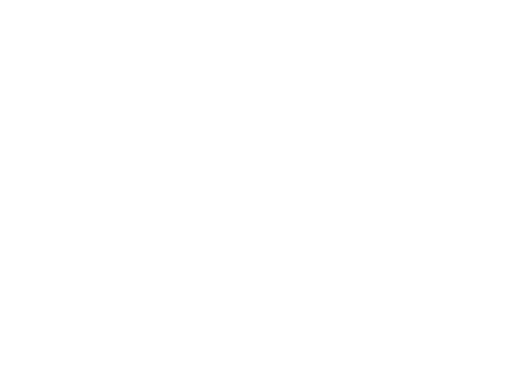

gravity


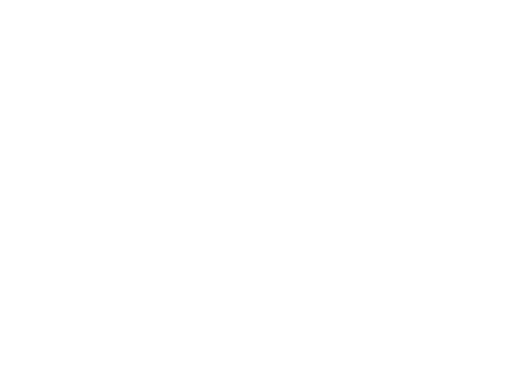

gravity


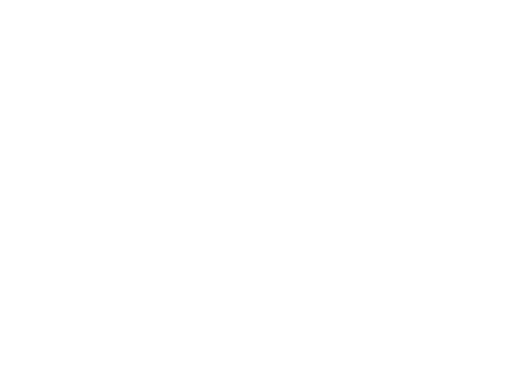

gravity


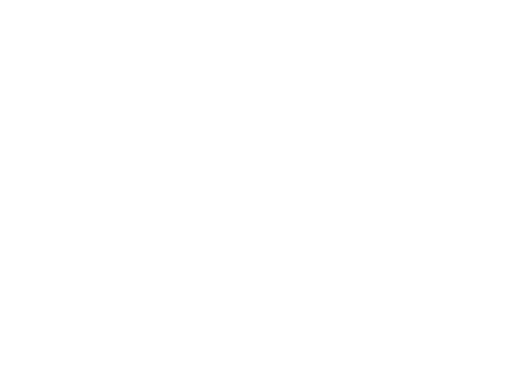

gravity


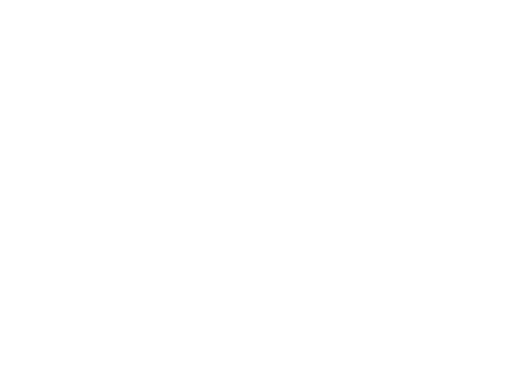

gravity


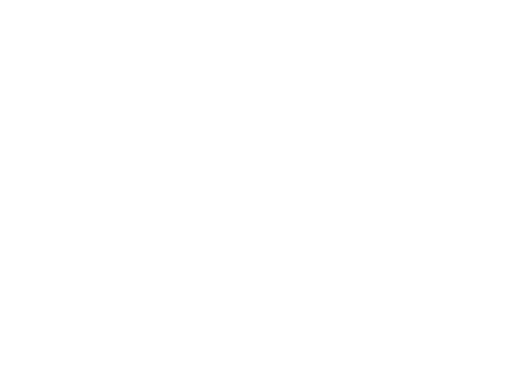

gravity


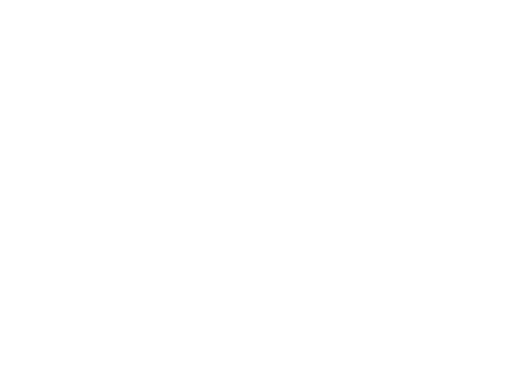

gravity


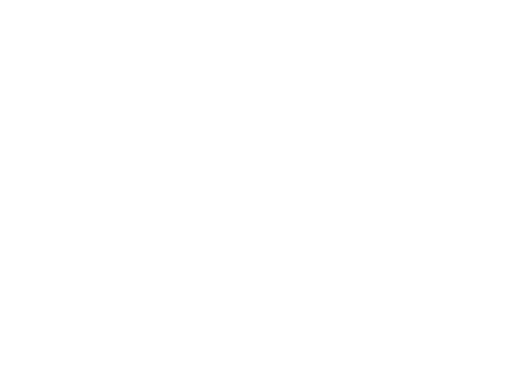

gravity


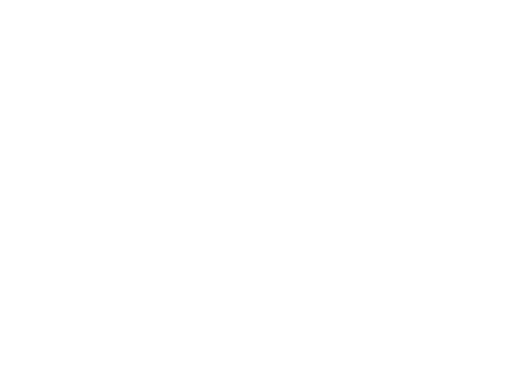

gravity


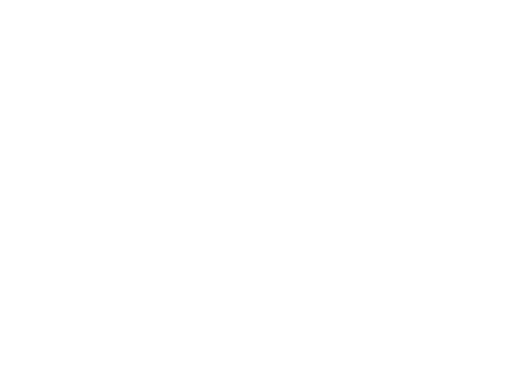

gravity


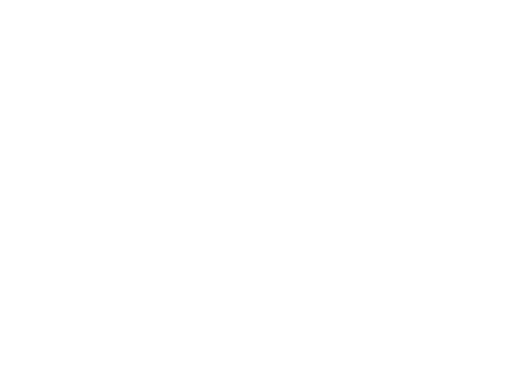

gravity


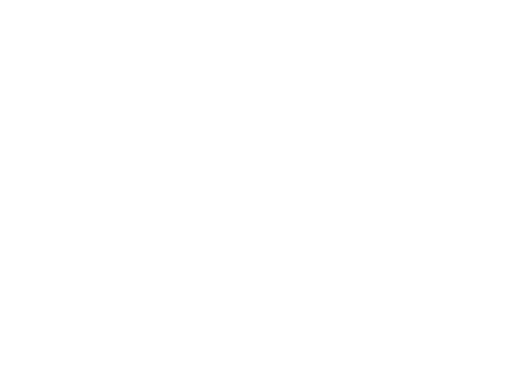

gravity


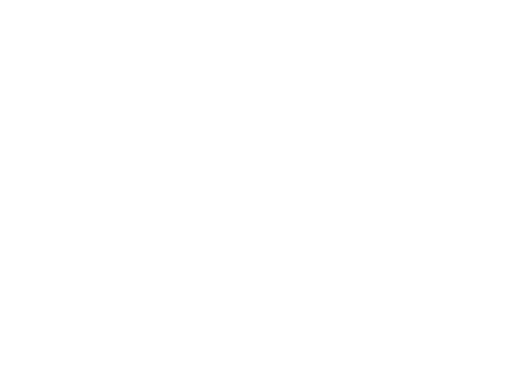

gravity


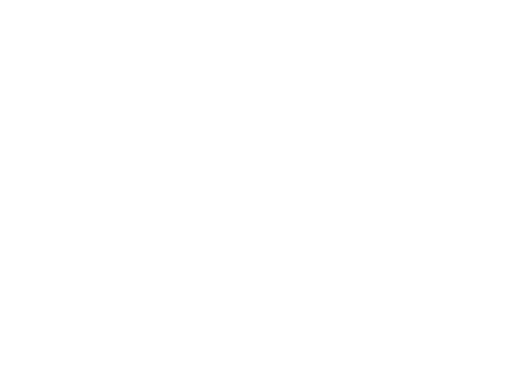

gravity


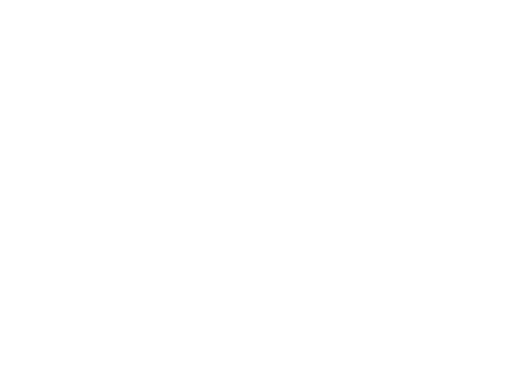

gravity


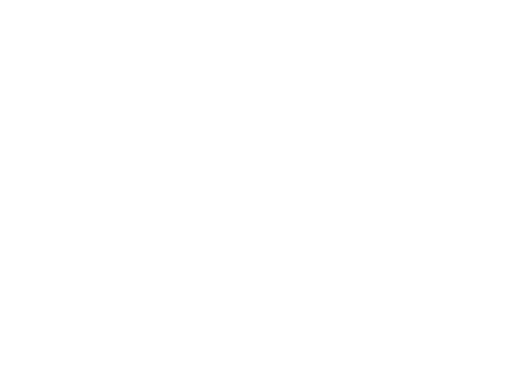

gravity


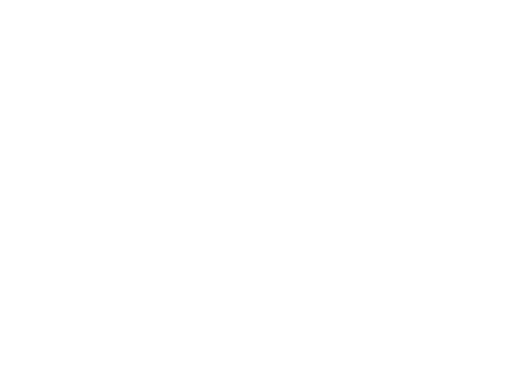

gravity


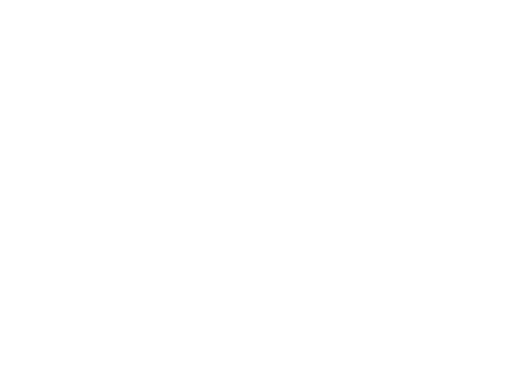

gravity


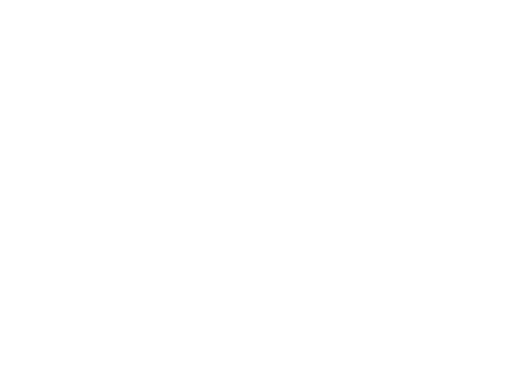

gravity


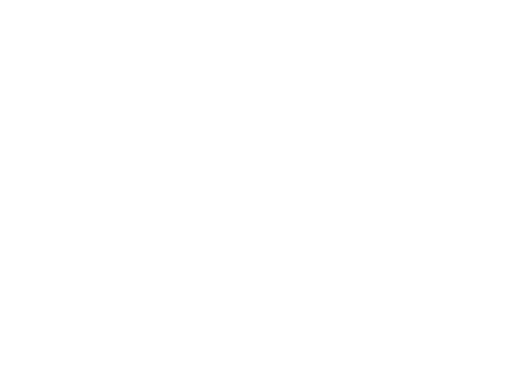

gravity


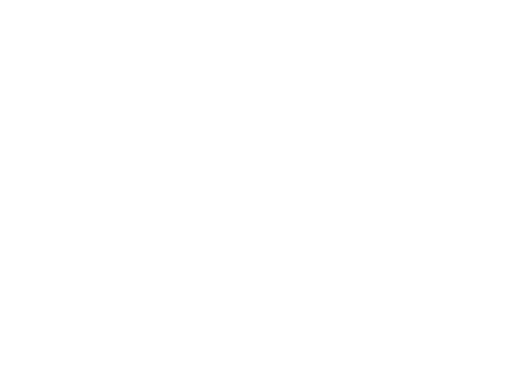

gravity


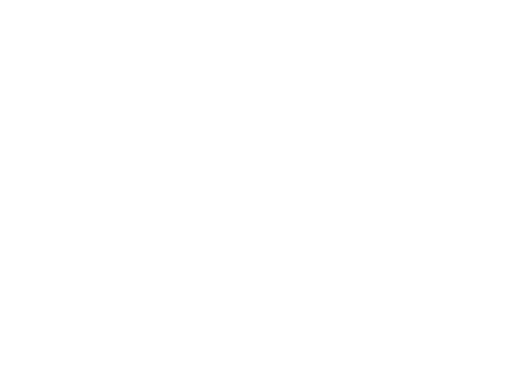

gravity


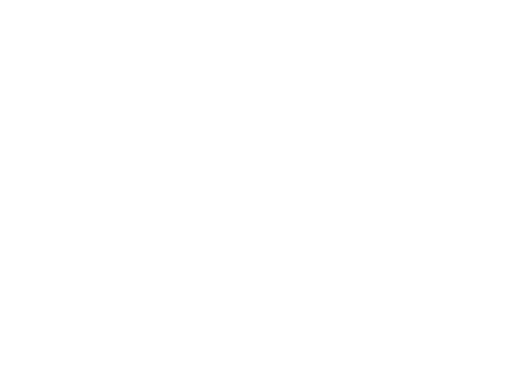

gravity


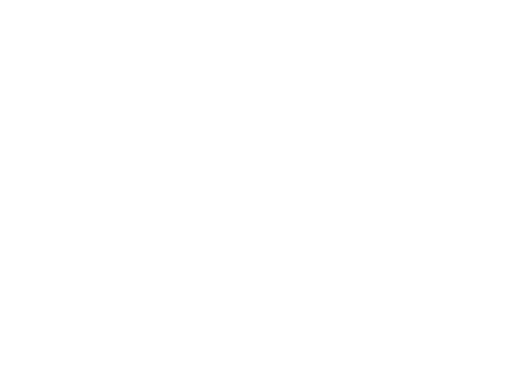

gravity


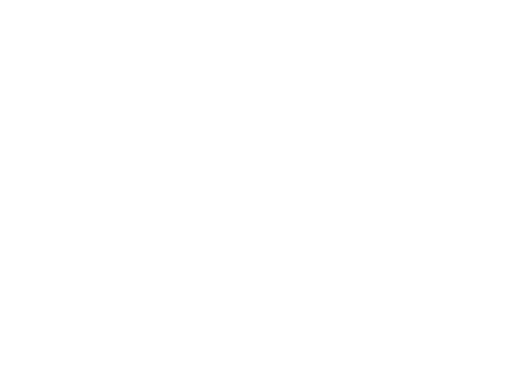

gravity


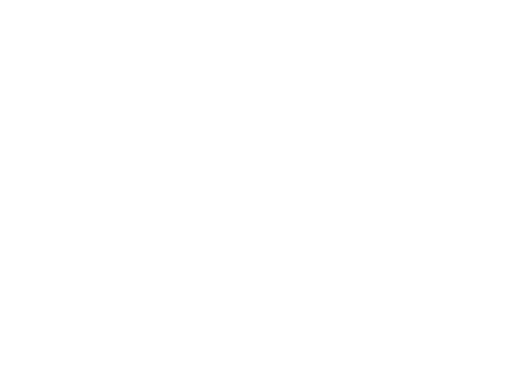

gravity


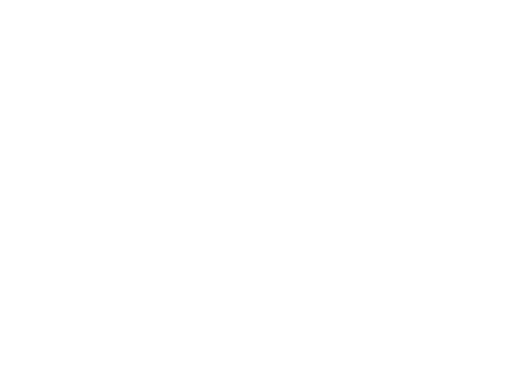

gravity


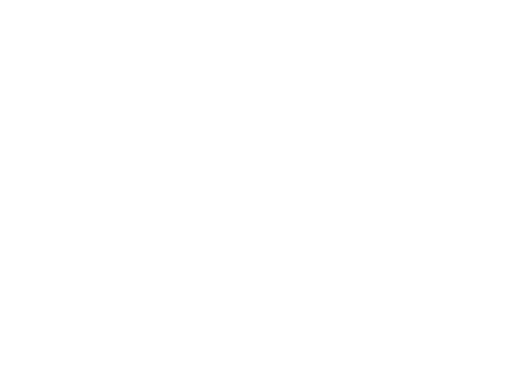

gravity


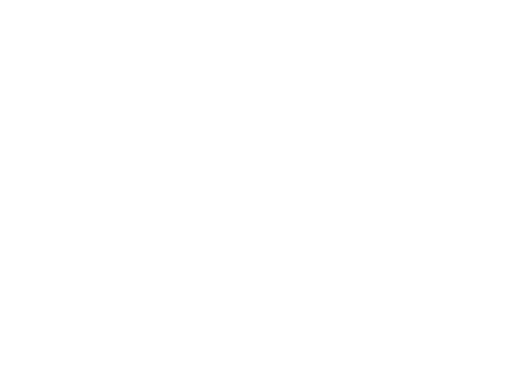

gravity


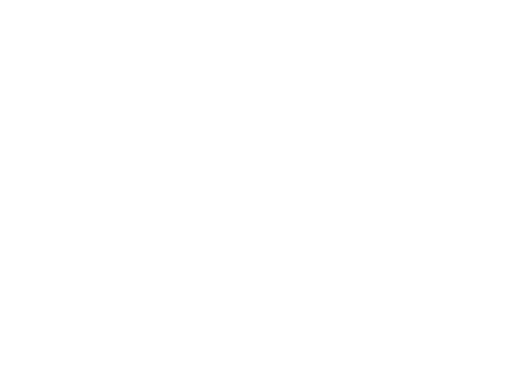

gravity
Current Placements: {(975, 197): 15}


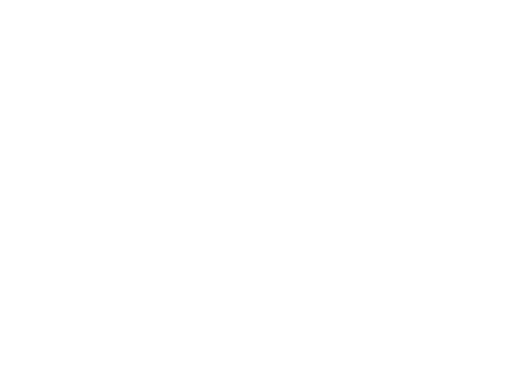

gravity


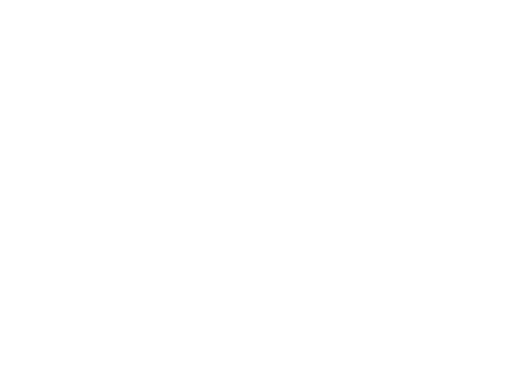

gravity


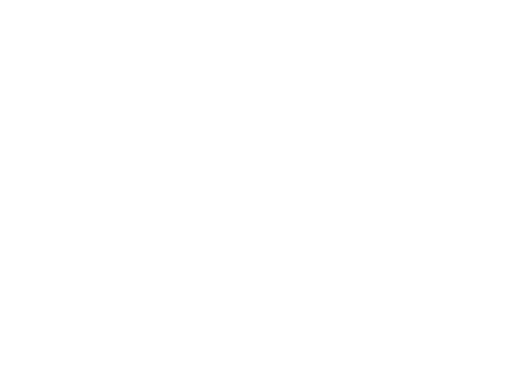

gravity


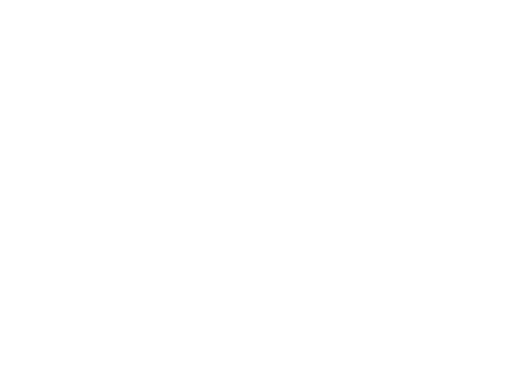

gravity


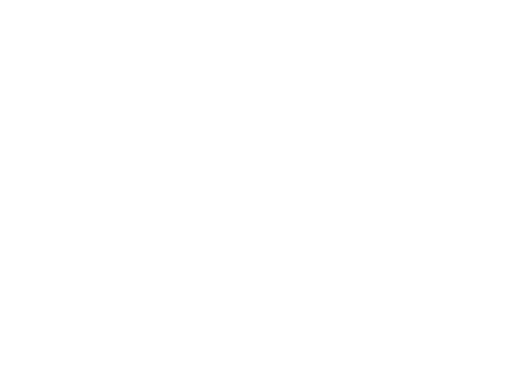

gravity


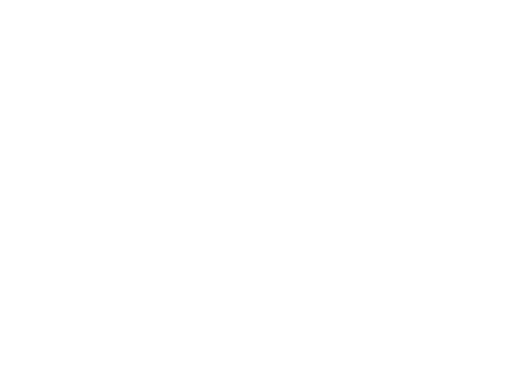

gravity


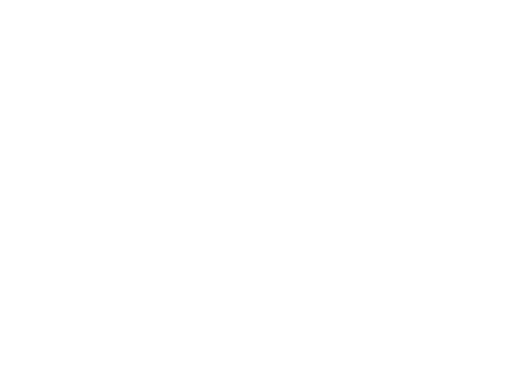

gravity


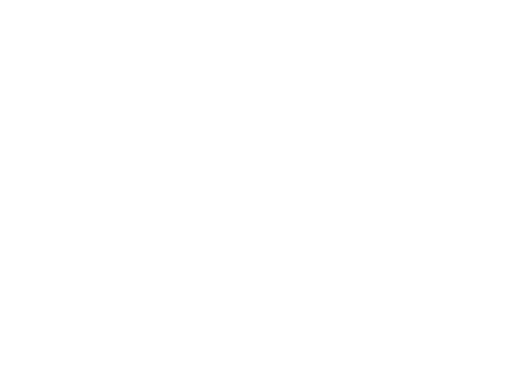

gravity


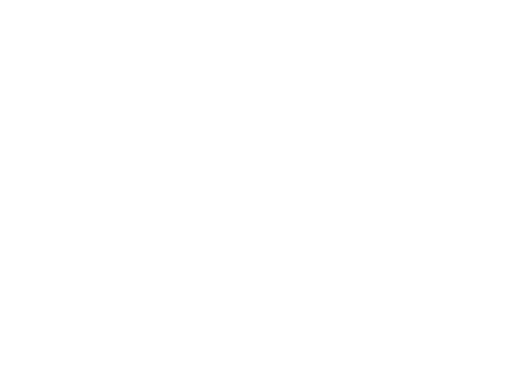

gravity


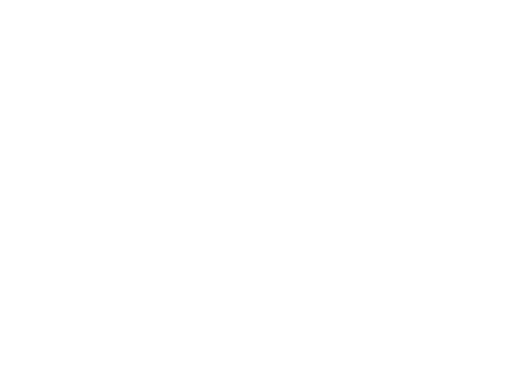

gravity


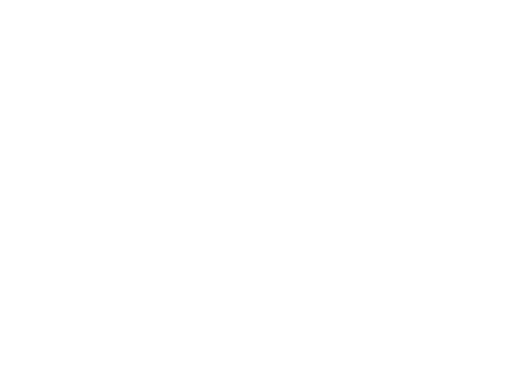

gravity


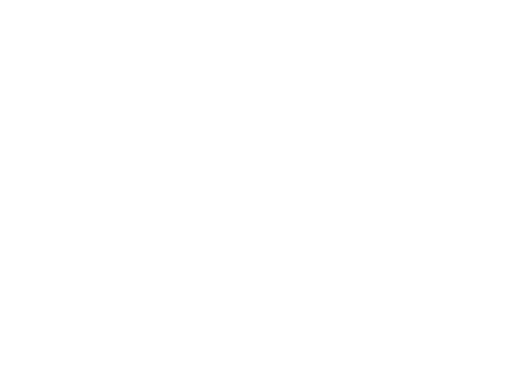

gravity


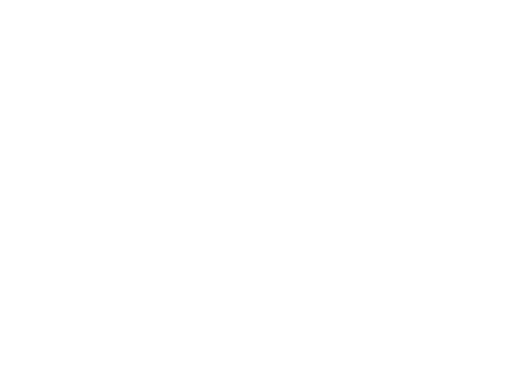

gravity


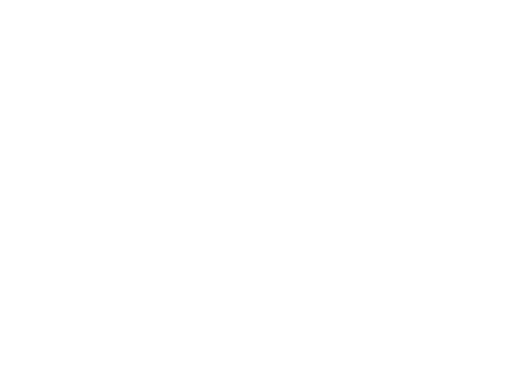

gravity


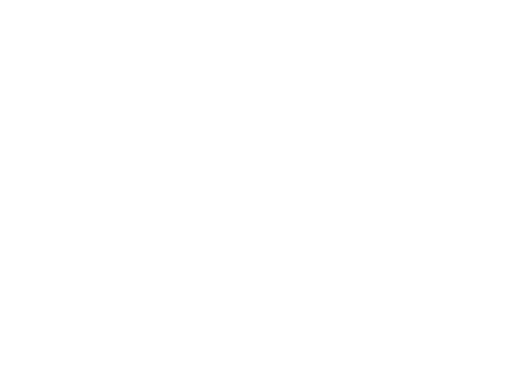

gravity


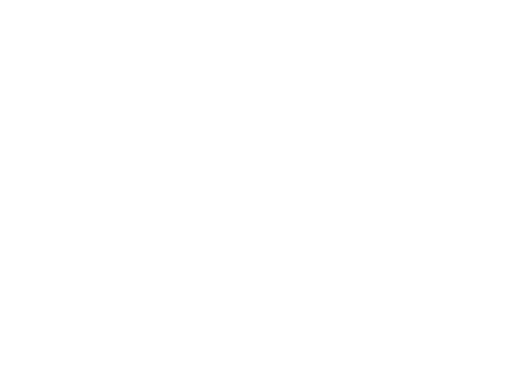

gravity


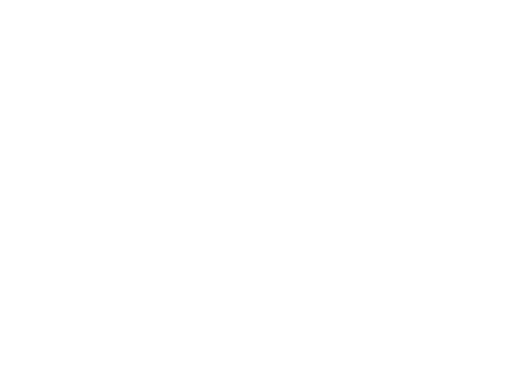

gravity


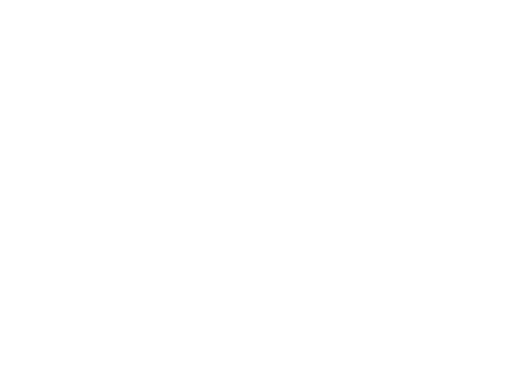

gravity


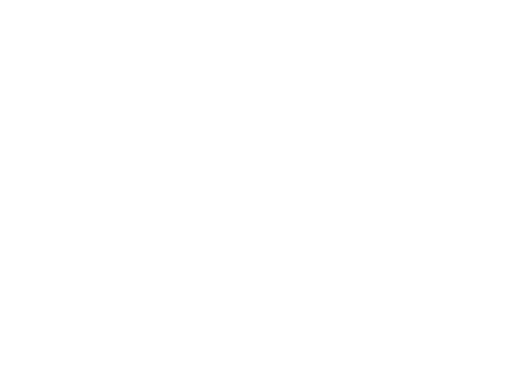

gravity


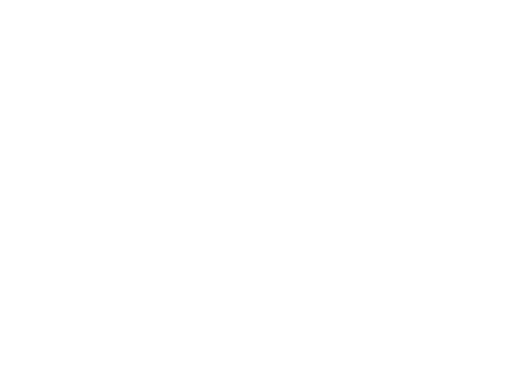

gravity


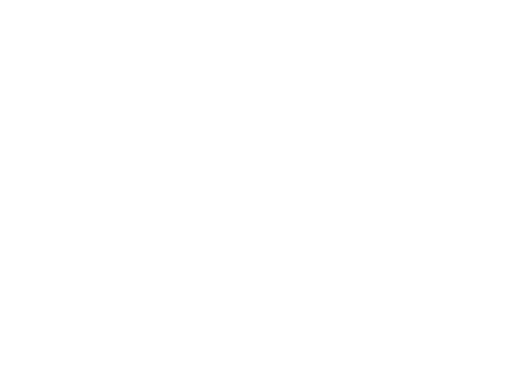

gravity


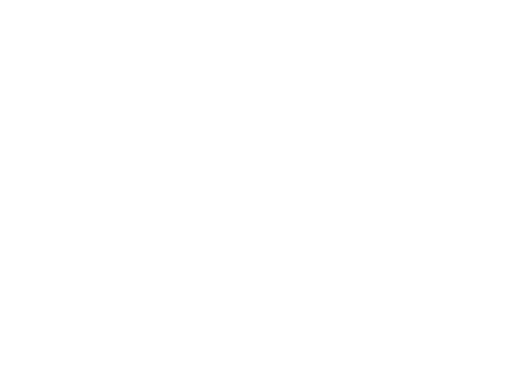

gravity


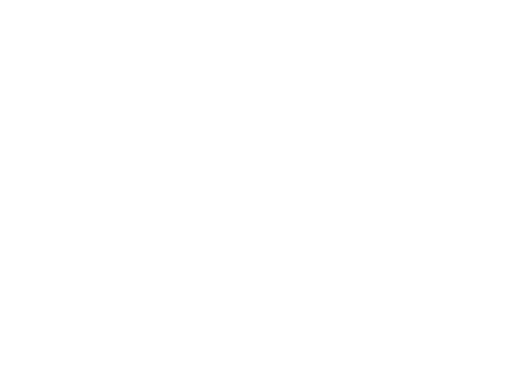

gravity


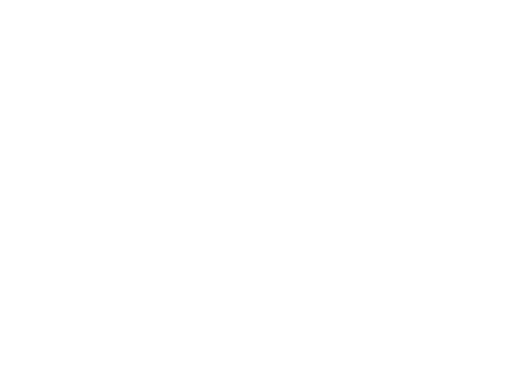

gravity


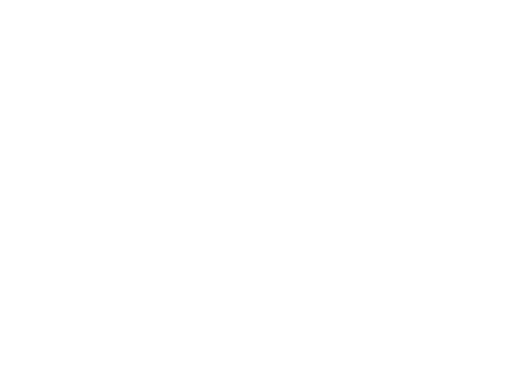

gravity


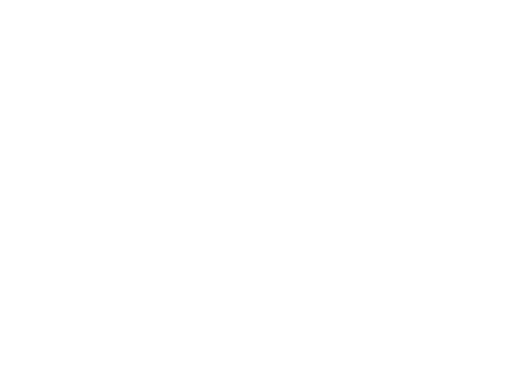

gravity


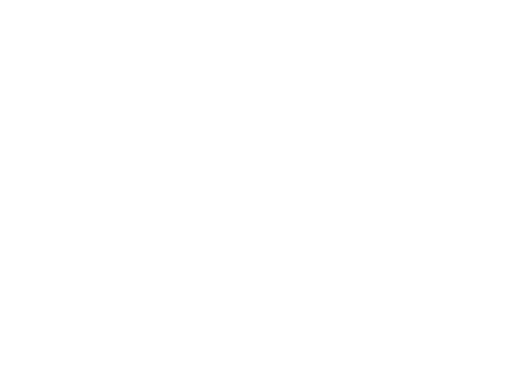

gravity


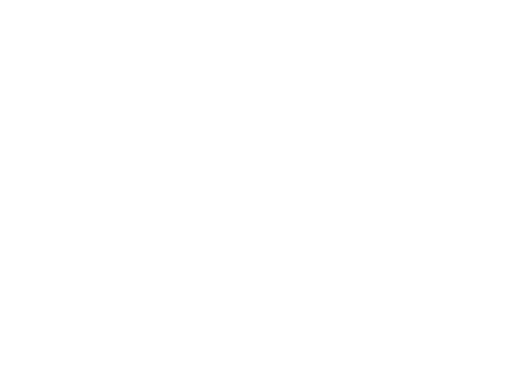

gravity


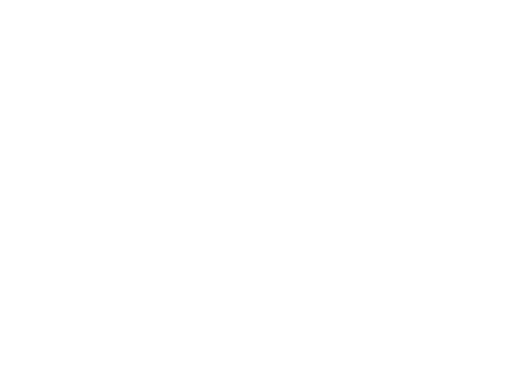

gravity


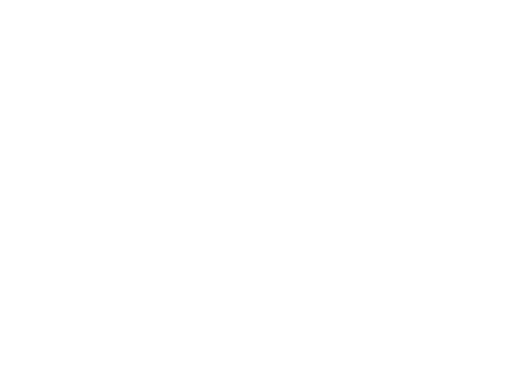

gravity


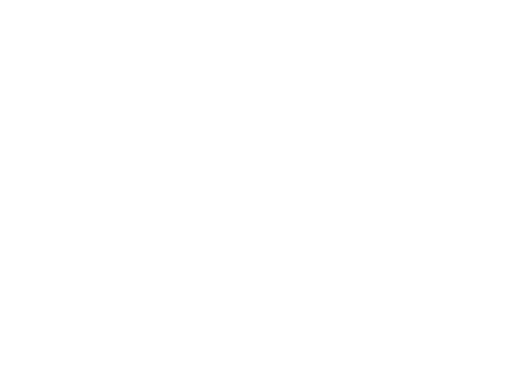

gravity
Current Placements: {(975, 197): 15, (975, 309): 15}


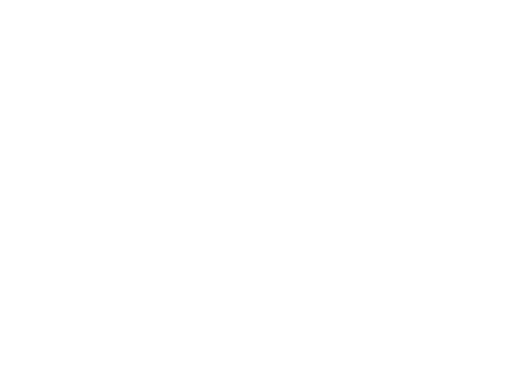

gravity


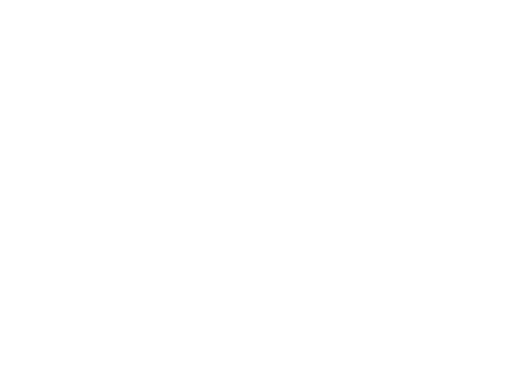

gravity


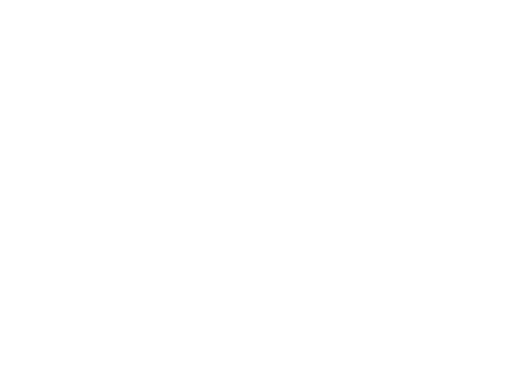

gravity


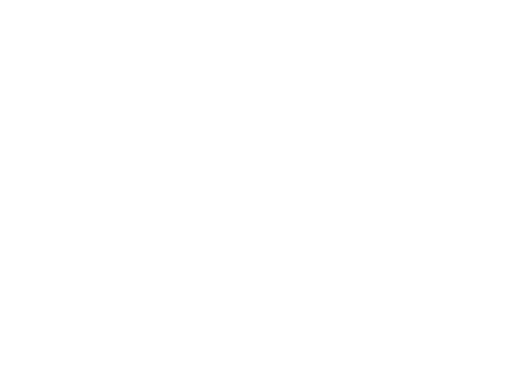

gravity


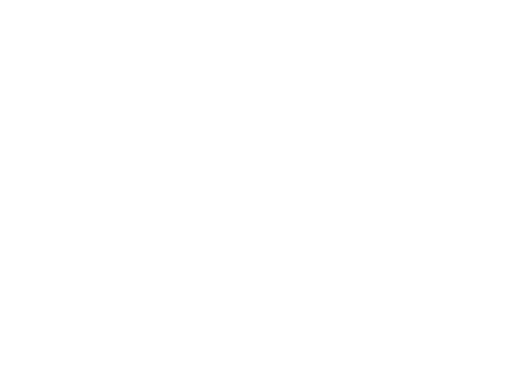

gravity


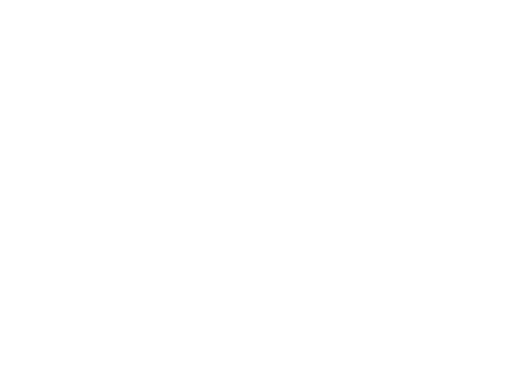

gravity


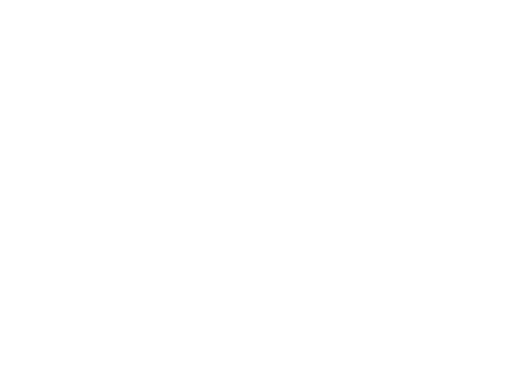

gravity


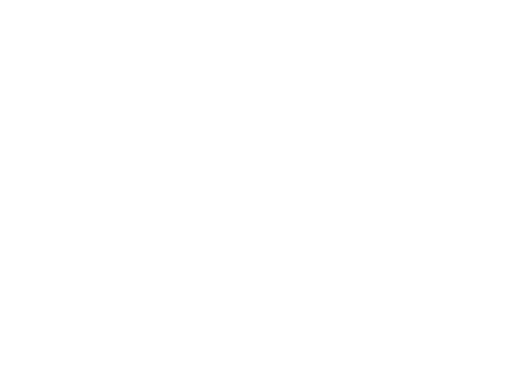

gravity


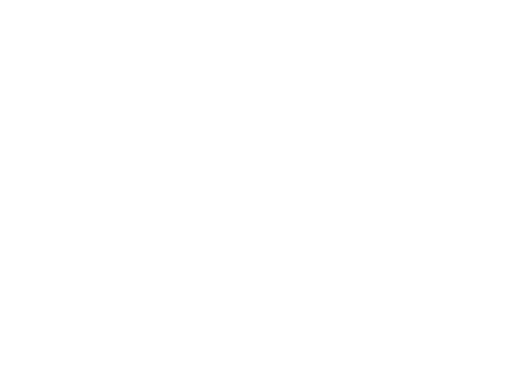

gravity


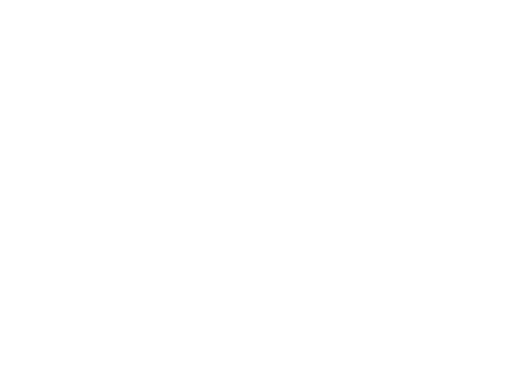

gravity


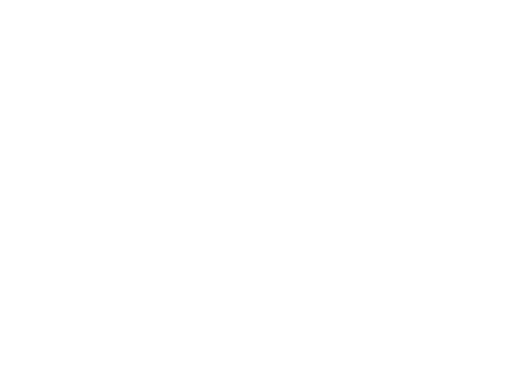

gravity


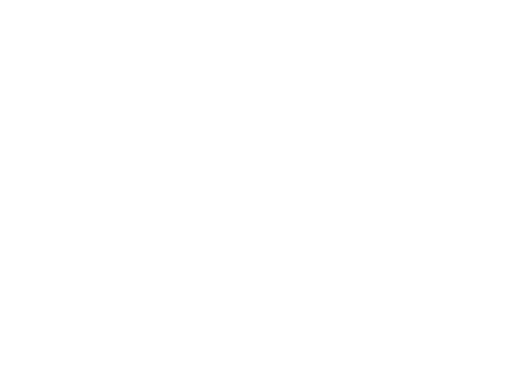

gravity


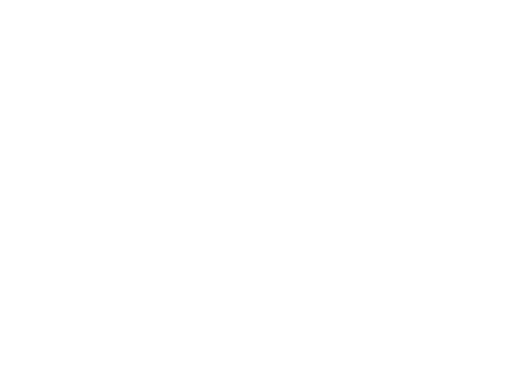

gravity


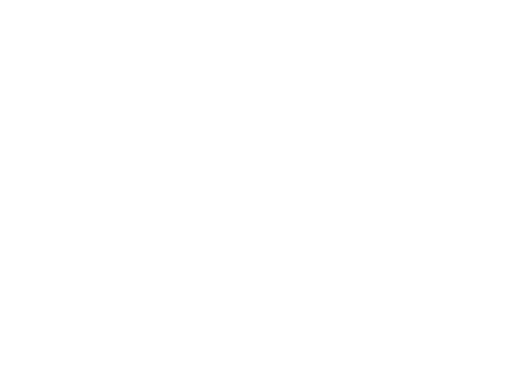

gravity


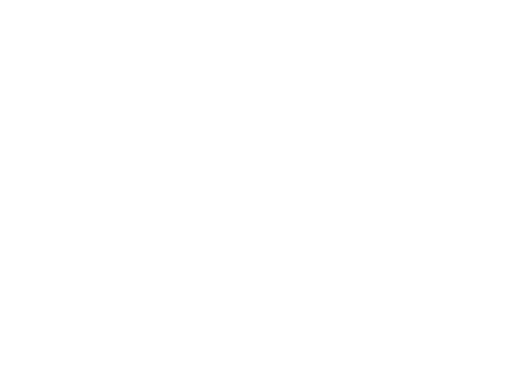

gravity


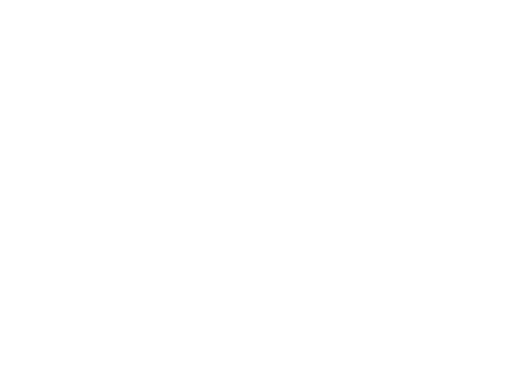

gravity


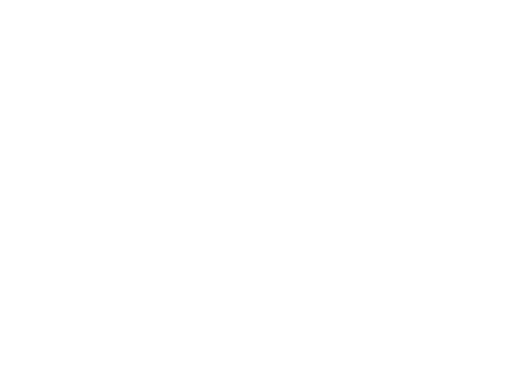

gravity


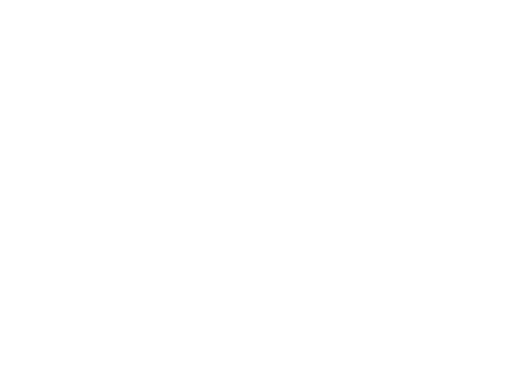

gravity


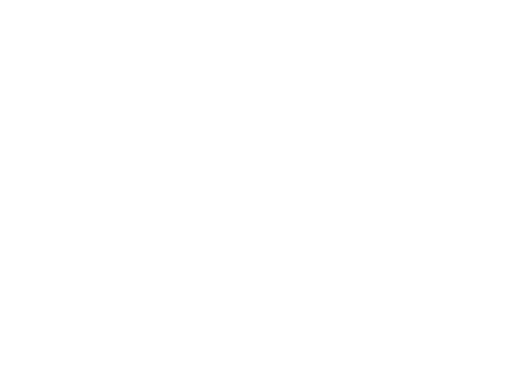

gravity


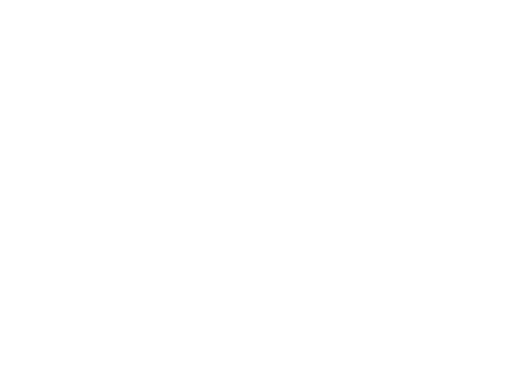

gravity


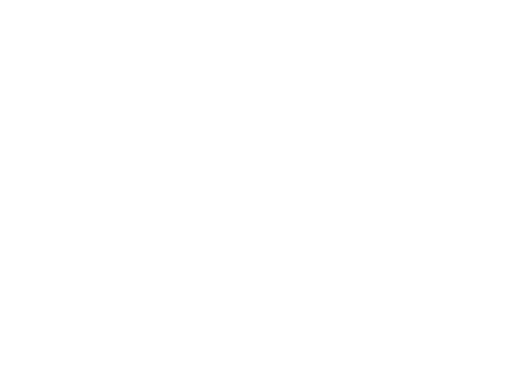

gravity


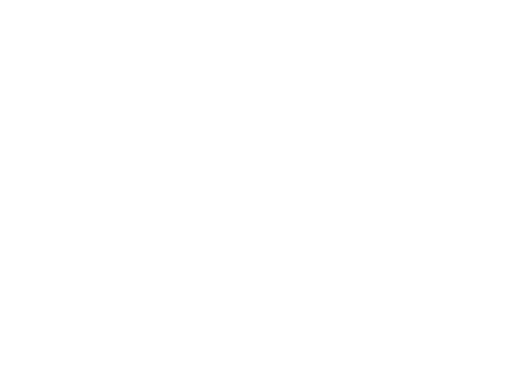

gravity


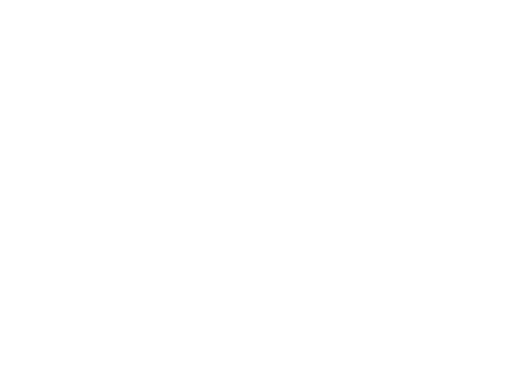

gravity


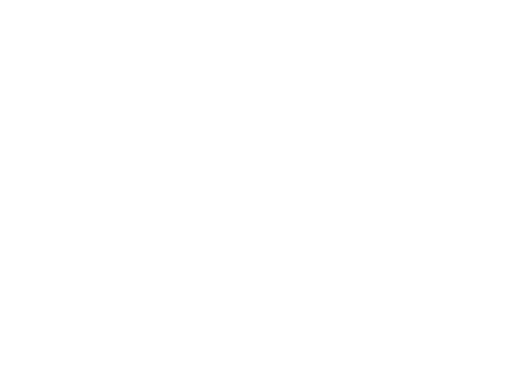

gravity


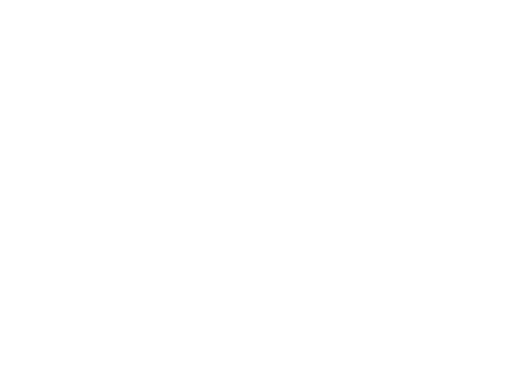

gravity


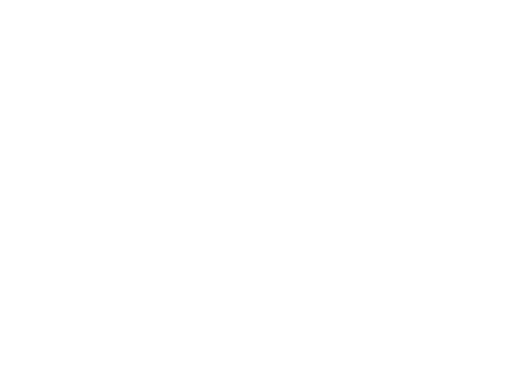

gravity


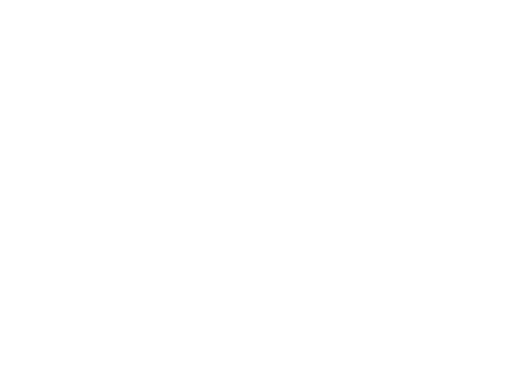

gravity


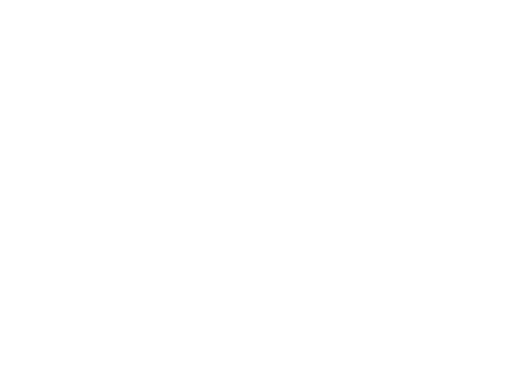

gravity


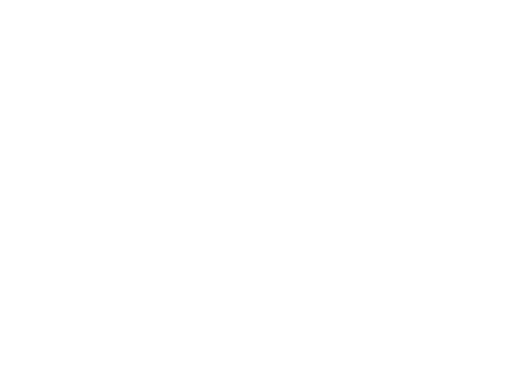

gravity


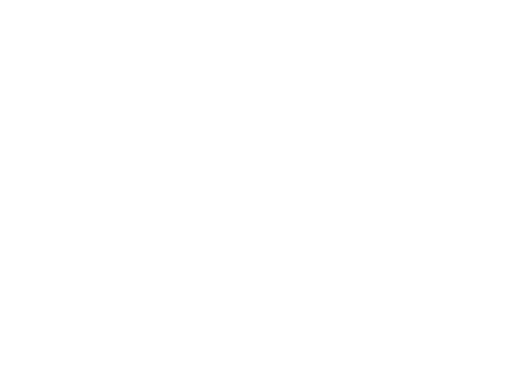

gravity


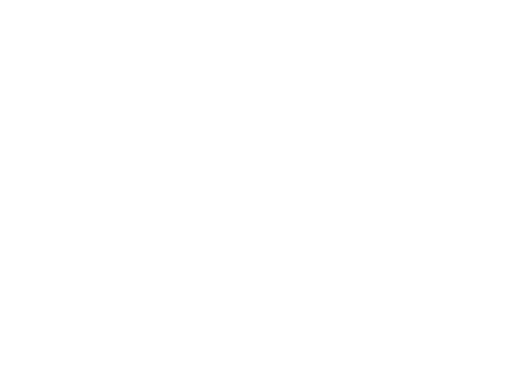

gravity
Current Placements: {(975, 197): 15, (975, 309): 15, (975, 259): 15}


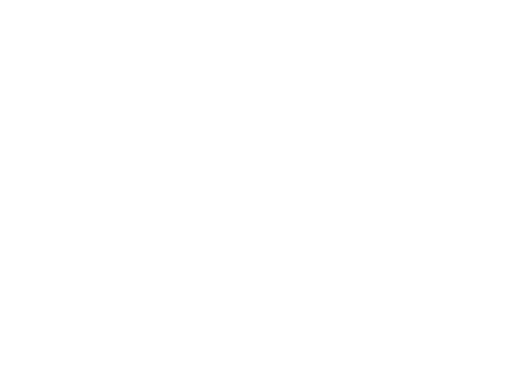

gravity


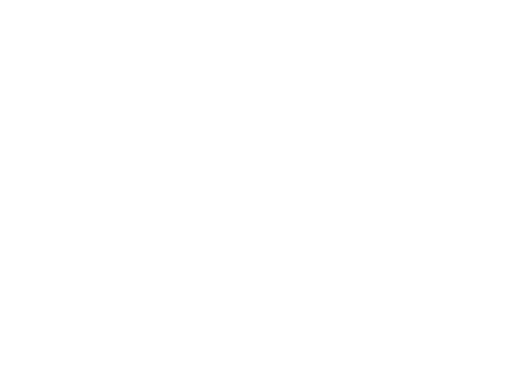

gravity


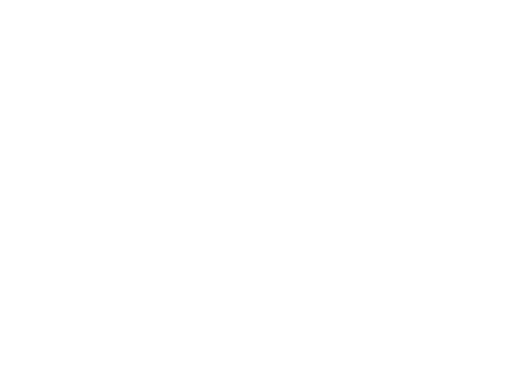

gravity


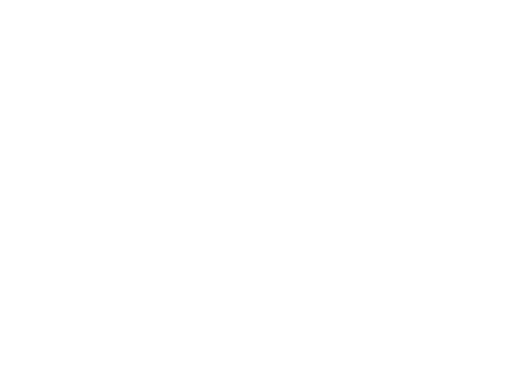

gravity


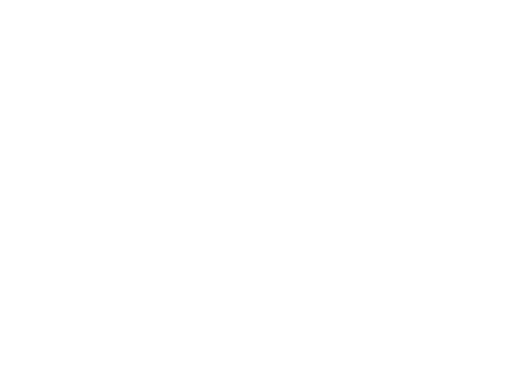

gravity


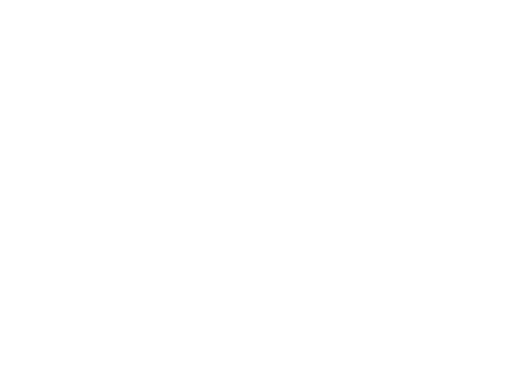

gravity


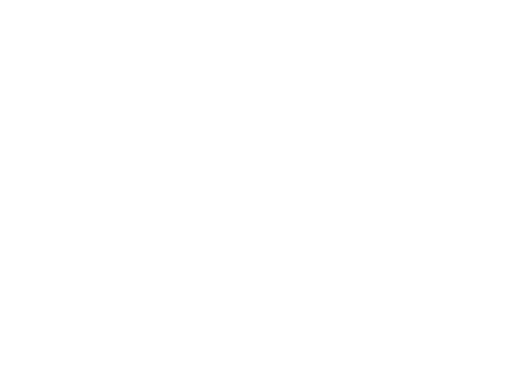

gravity


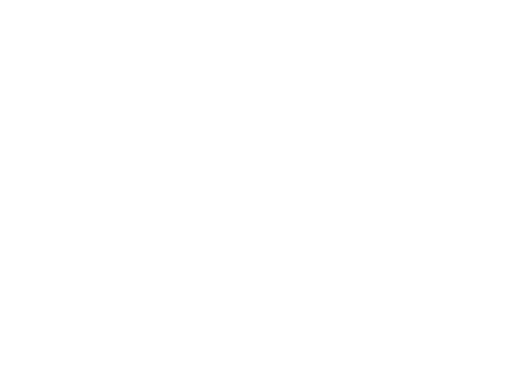

gravity


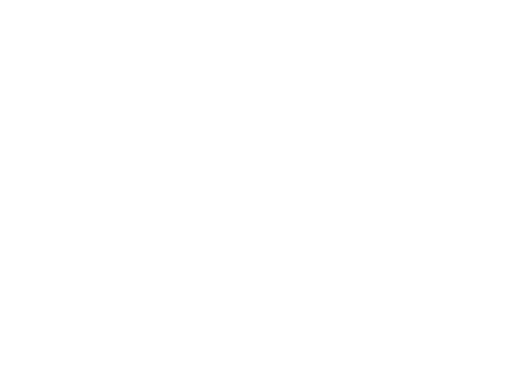

gravity


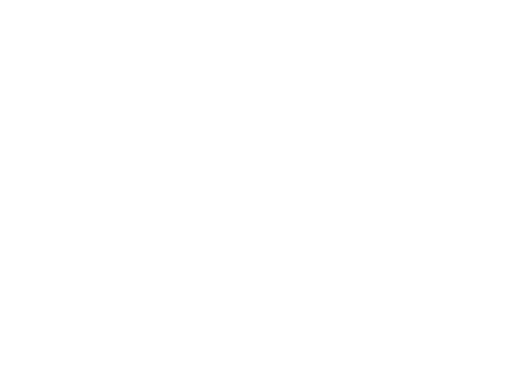

gravity


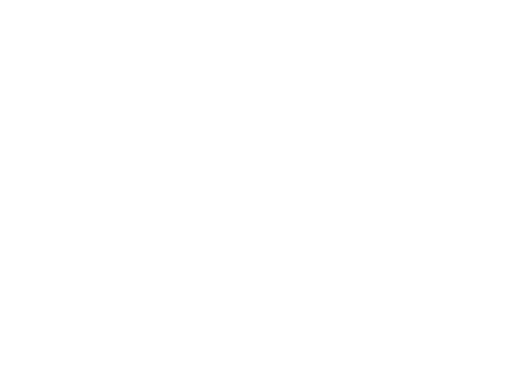

gravity


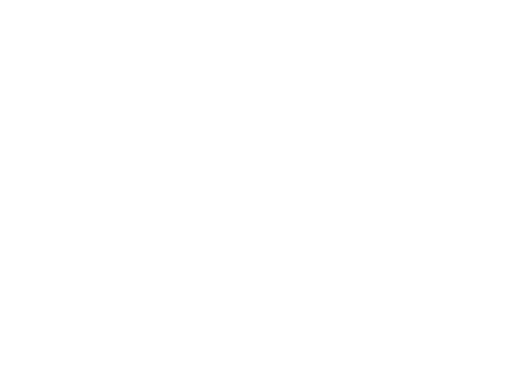

gravity


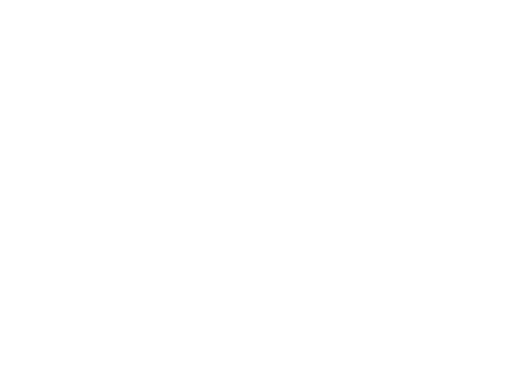

gravity


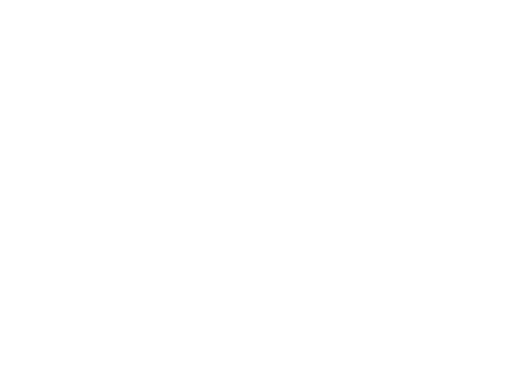

gravity


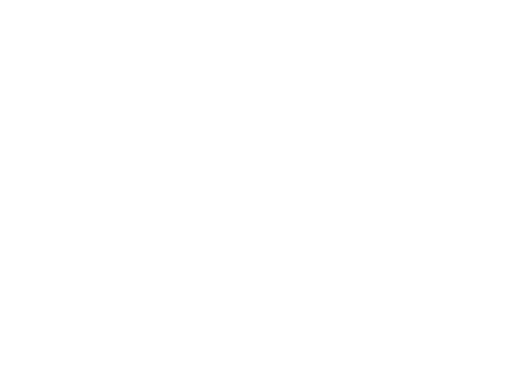

gravity


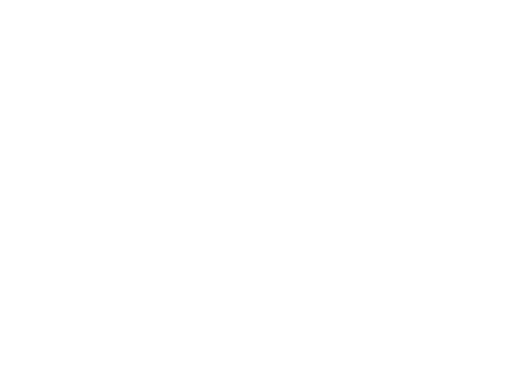

gravity


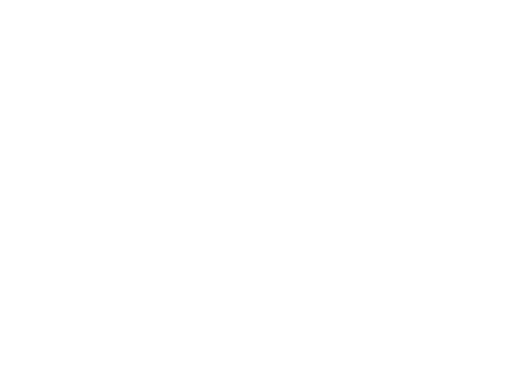

gravity


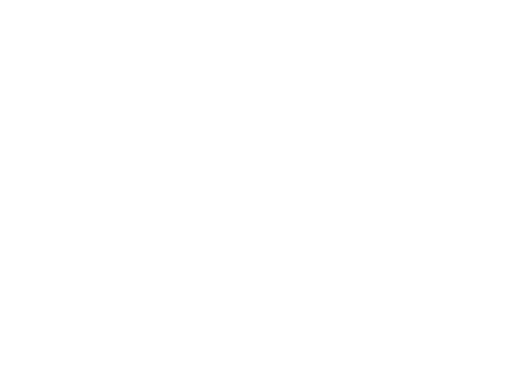

gravity


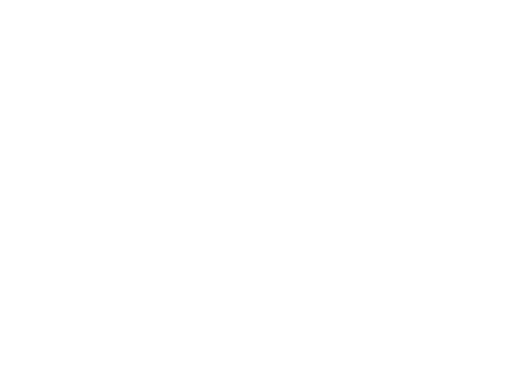

gravity


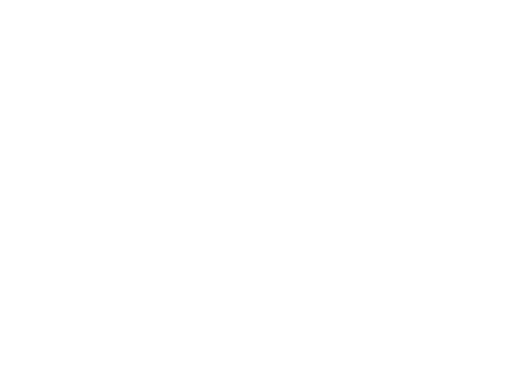

gravity


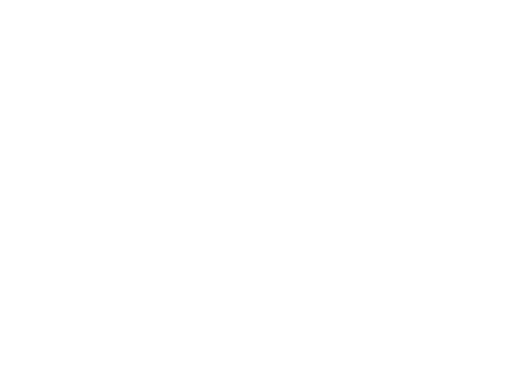

gravity


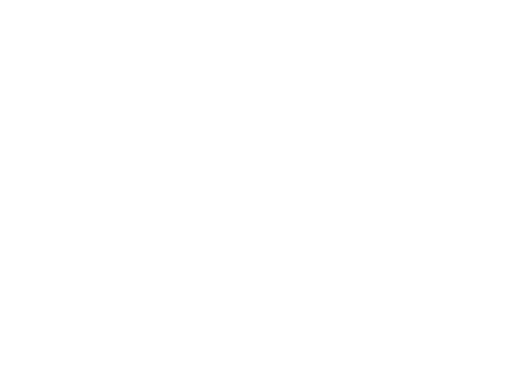

gravity


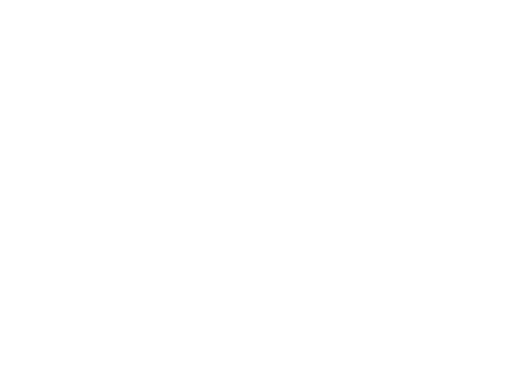

gravity


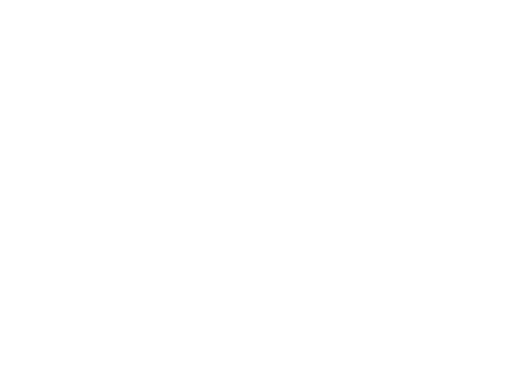

gravity


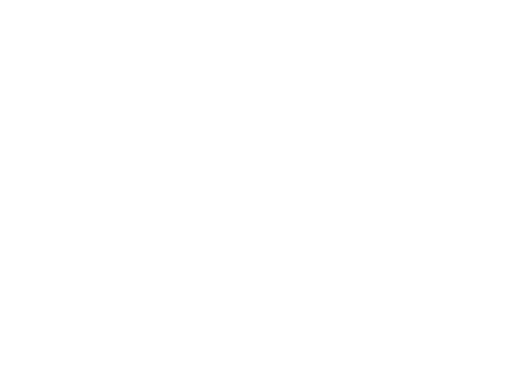

gravity


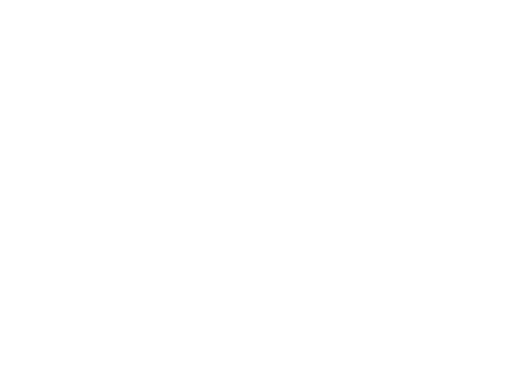

gravity


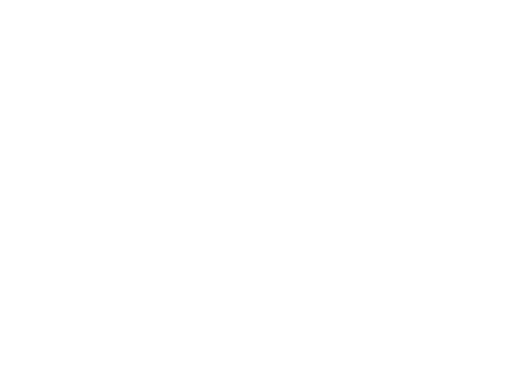

gravity


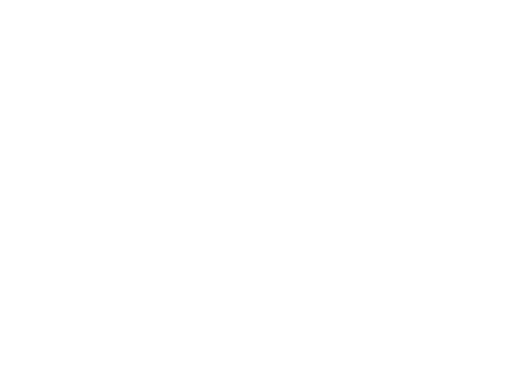

gravity


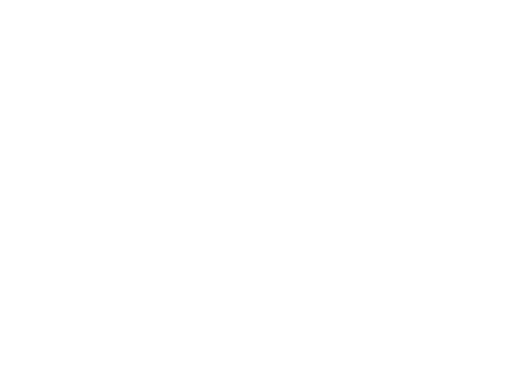

gravity


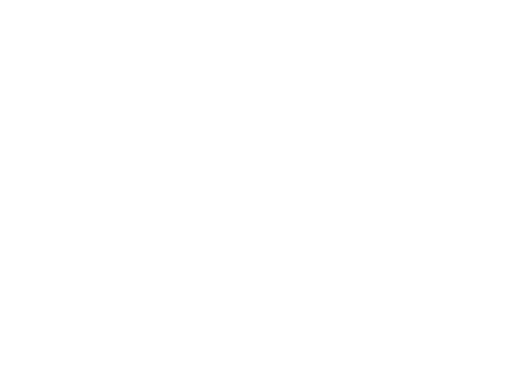

collision detected!
side wall False
side diff ball False
below wall False
below diff ball True
around wall False
around diff ball False


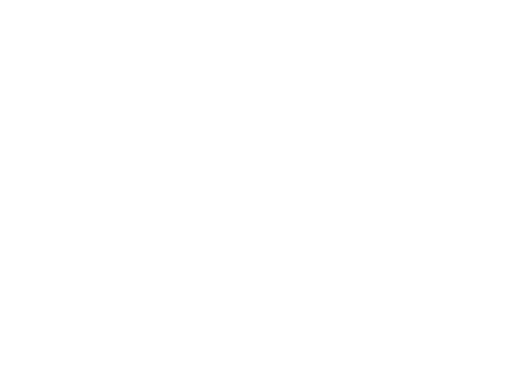

collision detected!
side wall False
side diff ball False
below wall False
below diff ball True
around wall False
around diff ball False


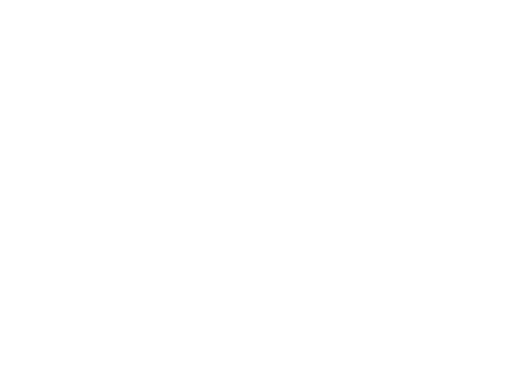

collision detected!
side wall False
side diff ball False
below wall False
below diff ball True
around wall False
around diff ball False


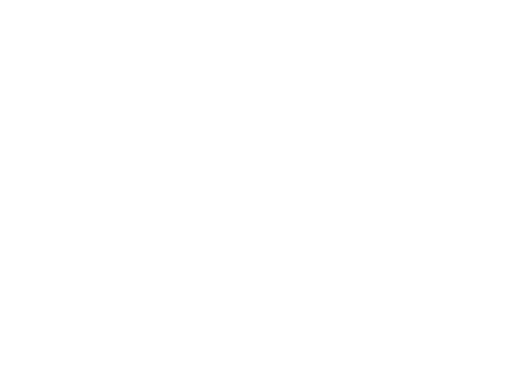

collision detected!
side wall False
side diff ball False
below wall False
below diff ball True
around wall False
around diff ball True


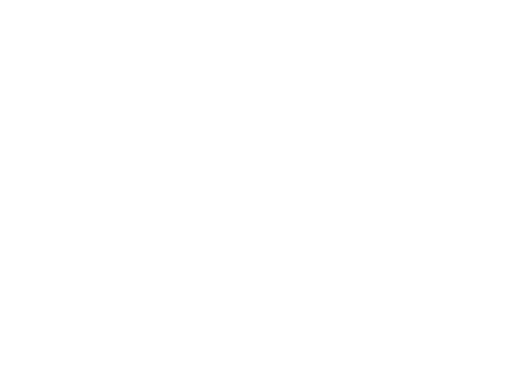

collision detected!
side wall False
side diff ball False
below wall False
below diff ball True
around wall False
around diff ball False


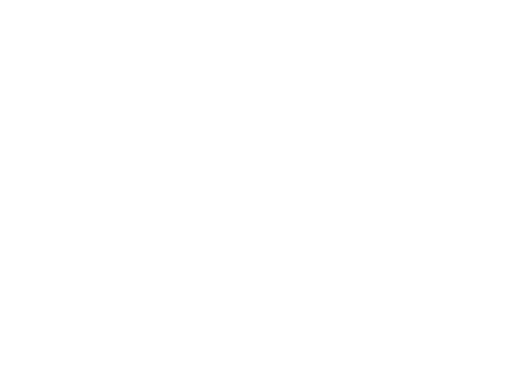

collision detected!
side wall False
side diff ball False
below wall False
below diff ball True
around wall False
around diff ball True


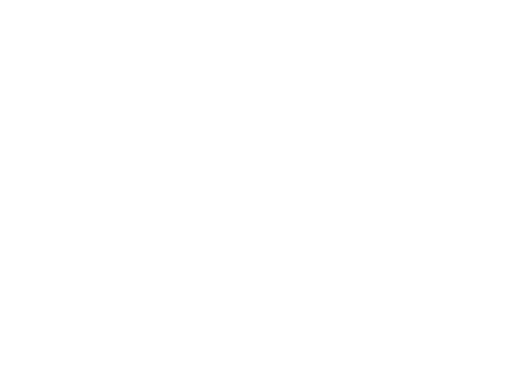

collision detected!
side wall False
side diff ball False
below wall False
below diff ball True
around wall False
around diff ball False


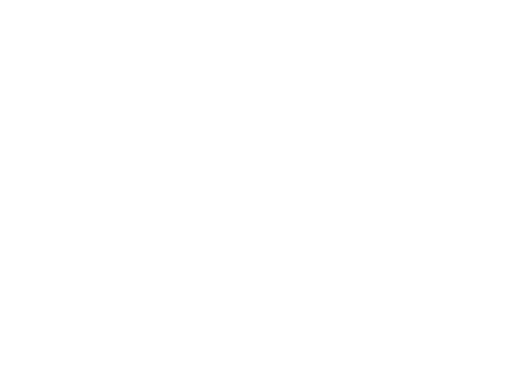

gravity
Current Placements: {(975, 197): 15, (975, 309): 15, (975, 259): 15, (960, 366): 30}


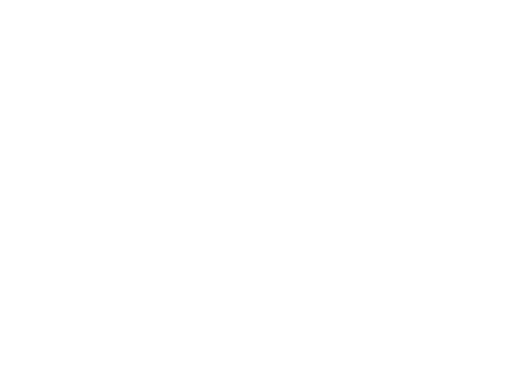

gravity


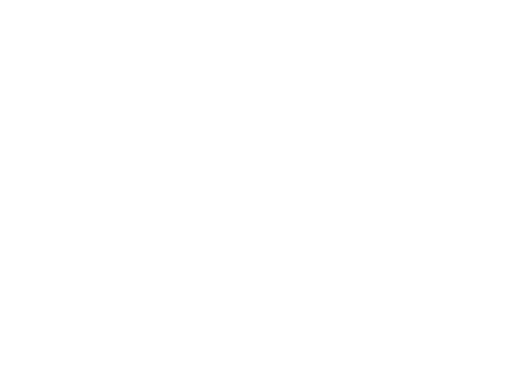

gravity


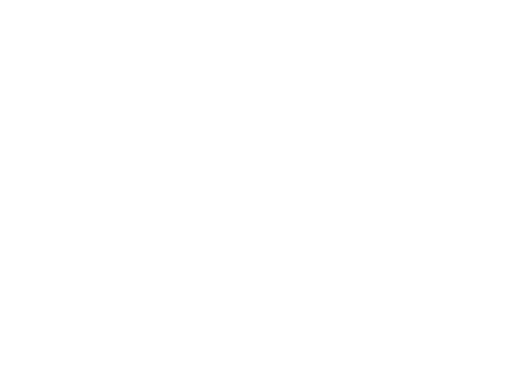

gravity


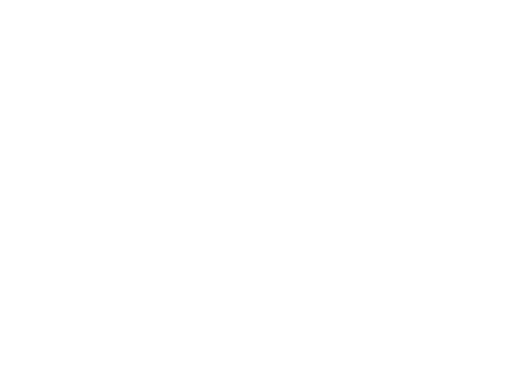

gravity


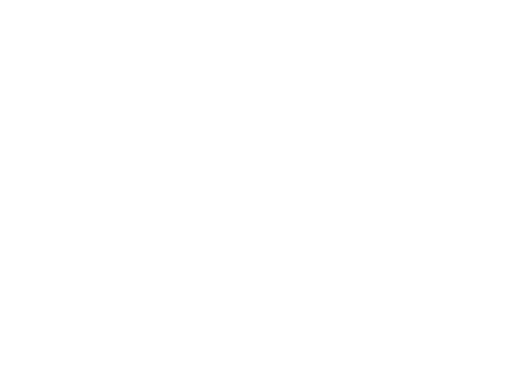

gravity


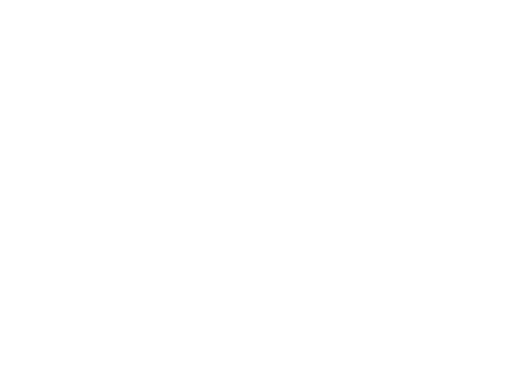

gravity


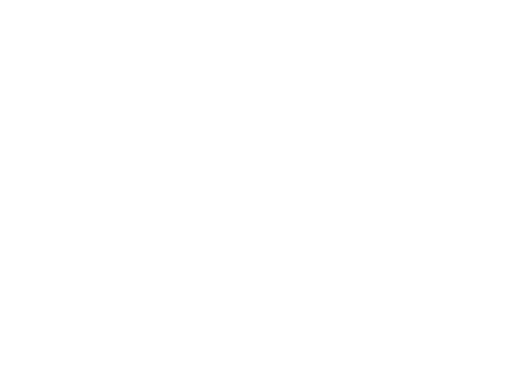

gravity


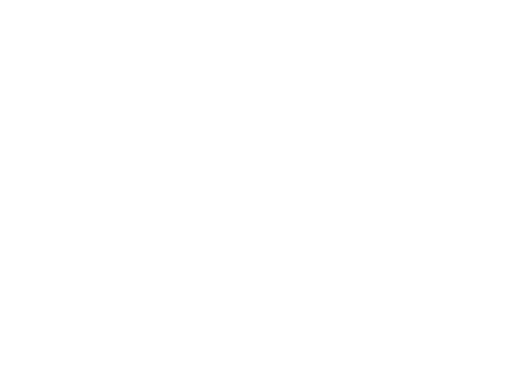

gravity


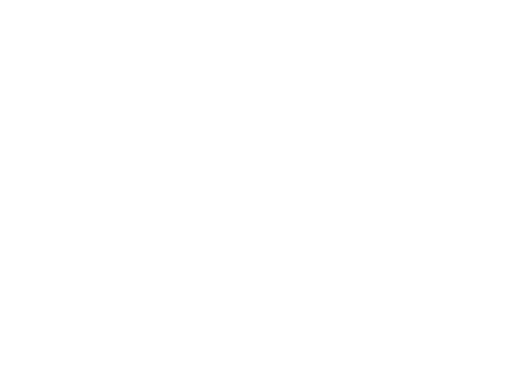

gravity


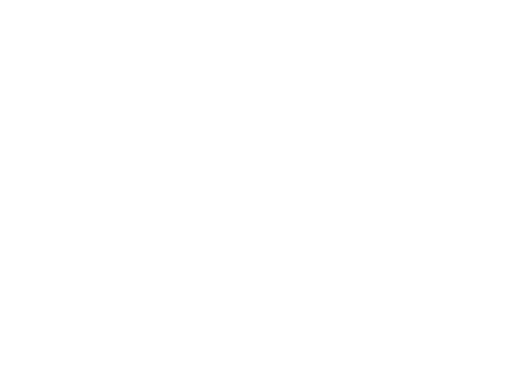

gravity


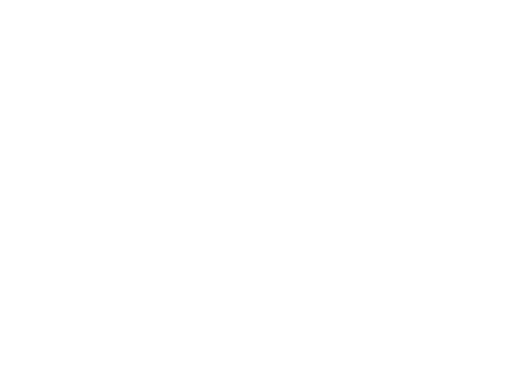

gravity


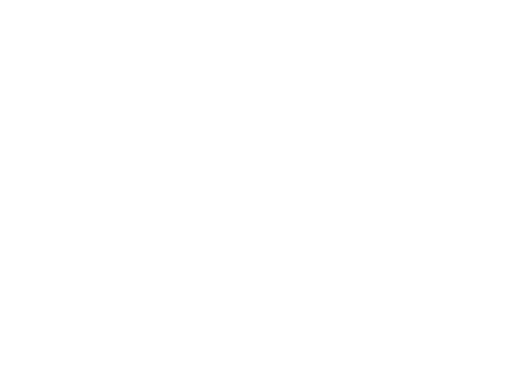

gravity


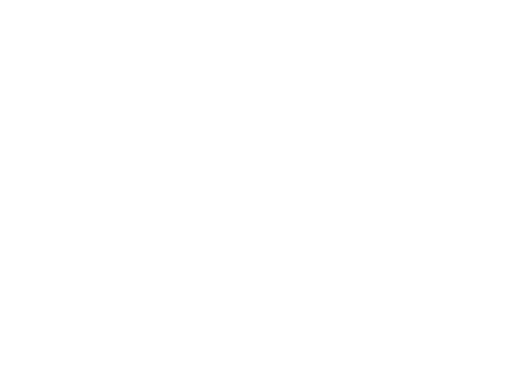

gravity


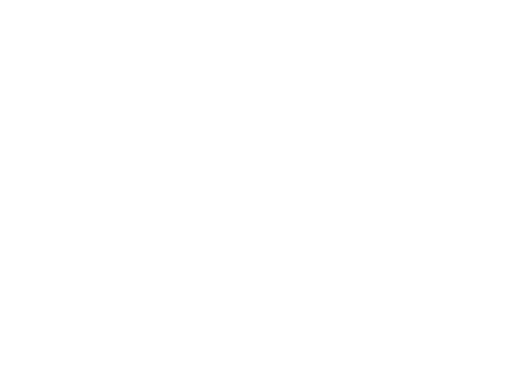

gravity


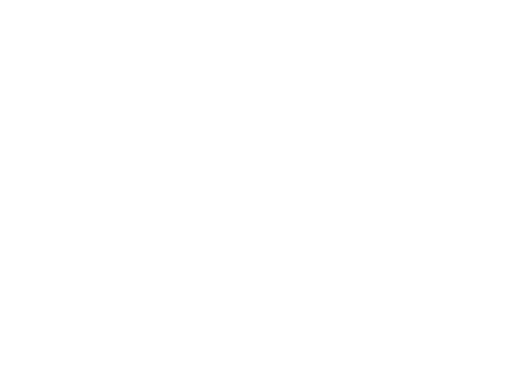

gravity


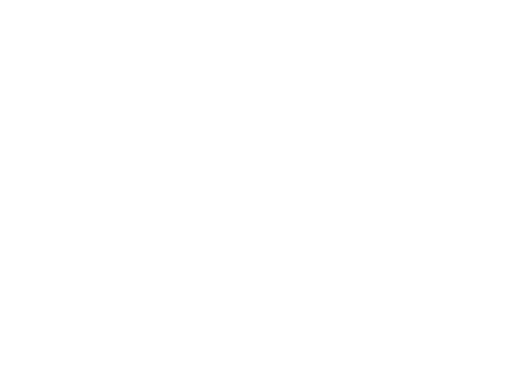

gravity


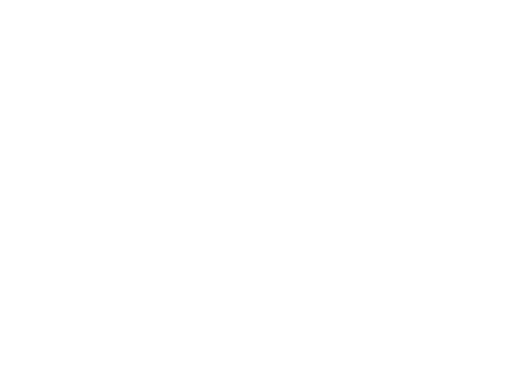

gravity


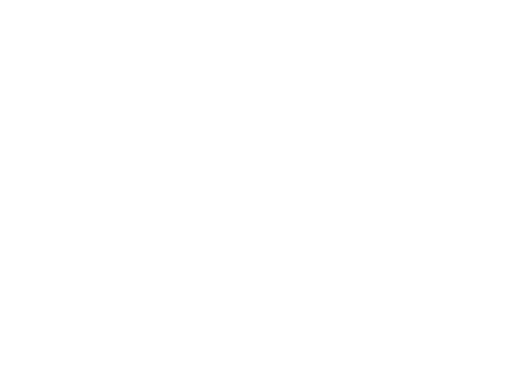

gravity


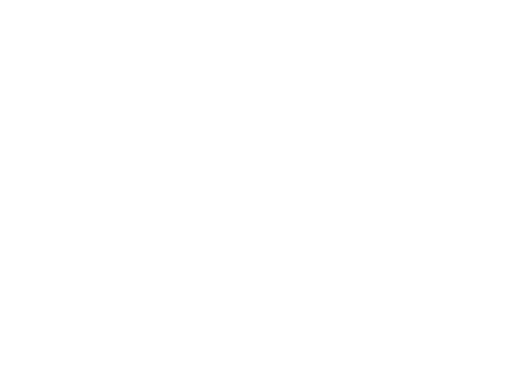

gravity


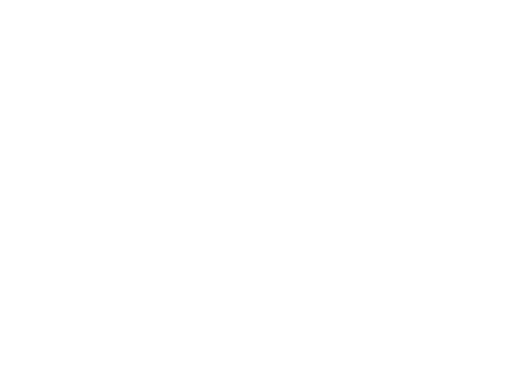

gravity


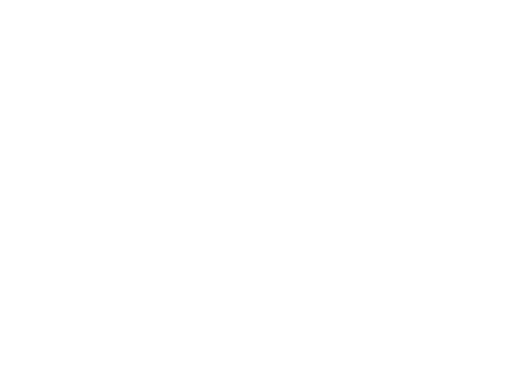

gravity


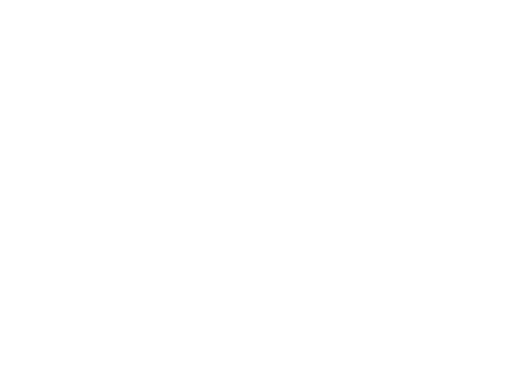

gravity


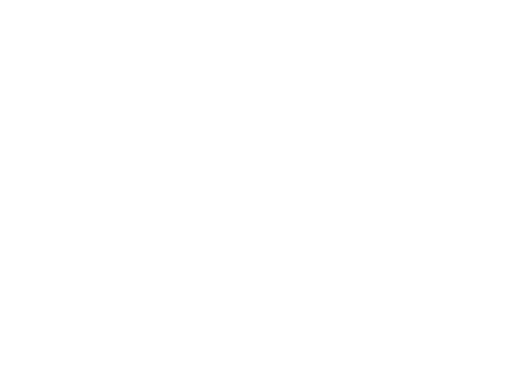

gravity


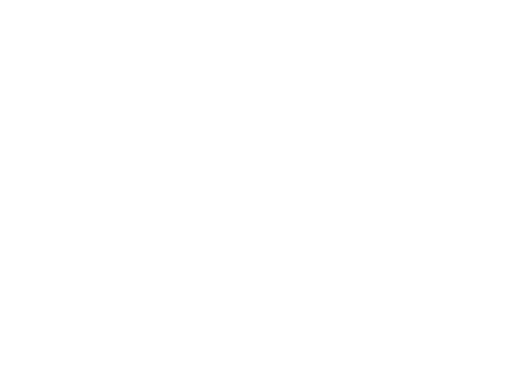

gravity


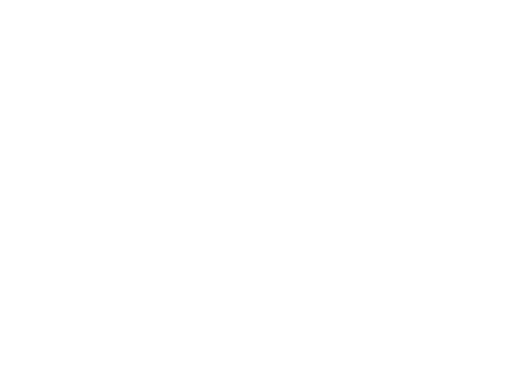

gravity


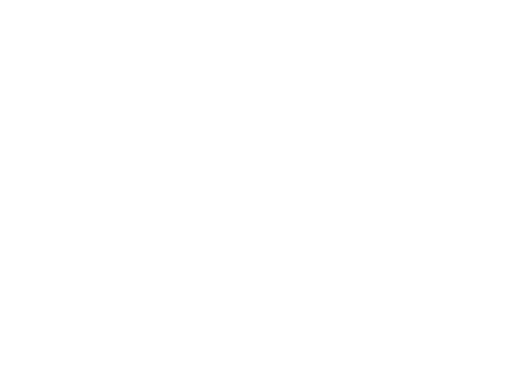

gravity


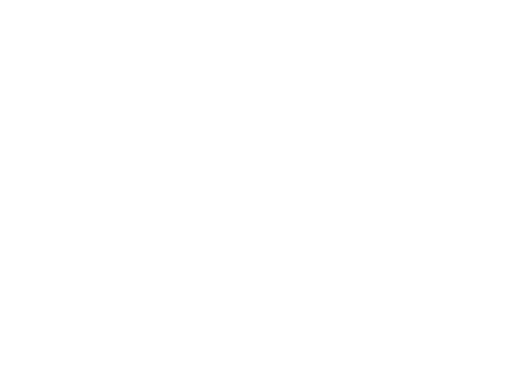

gravity


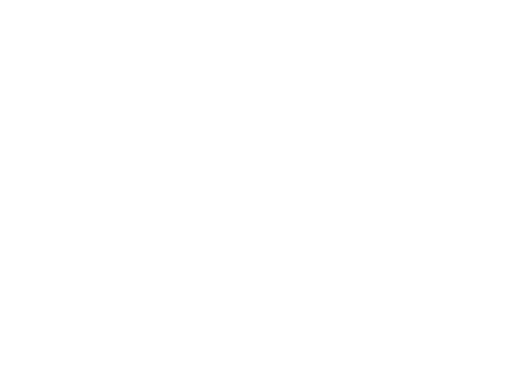

gravity


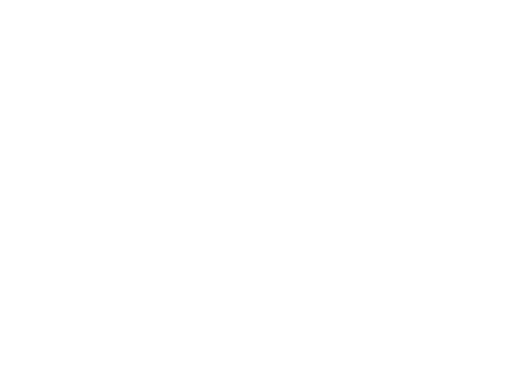

collision detected!
side wall False
side diff ball True
below wall False
below diff ball True
around wall False
around diff ball True
Current Placements: {(975, 197): 15, (975, 309): 15, (975, 259): 15, (960, 366): 30, (915, 306): 45}


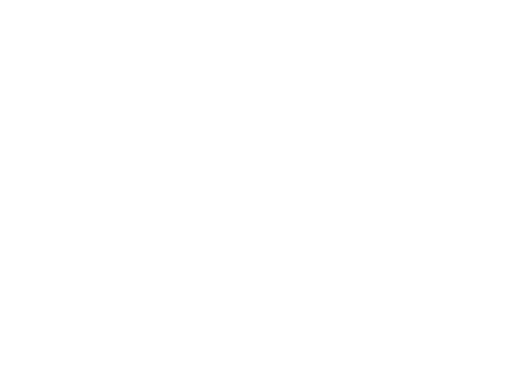

gravity


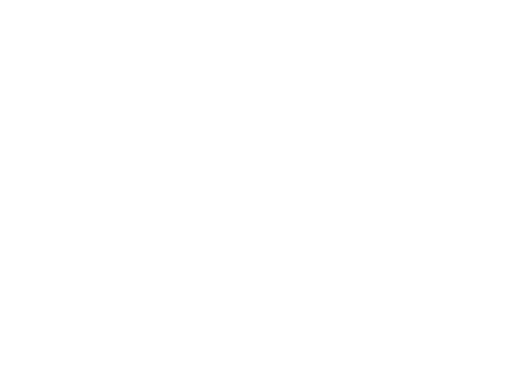

gravity


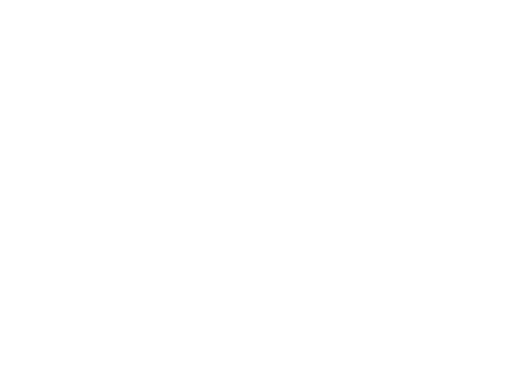

gravity


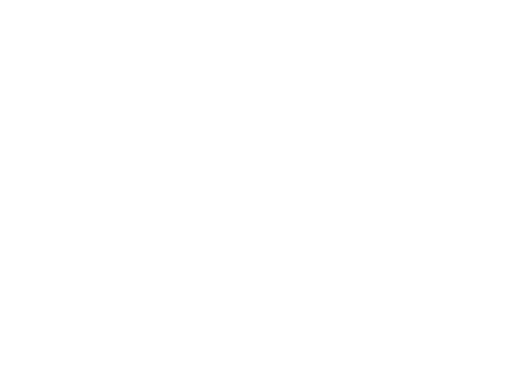

gravity


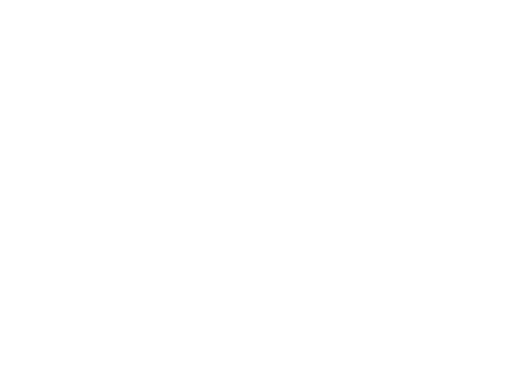

gravity


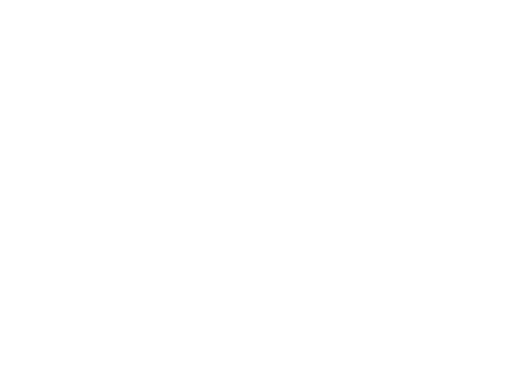

gravity


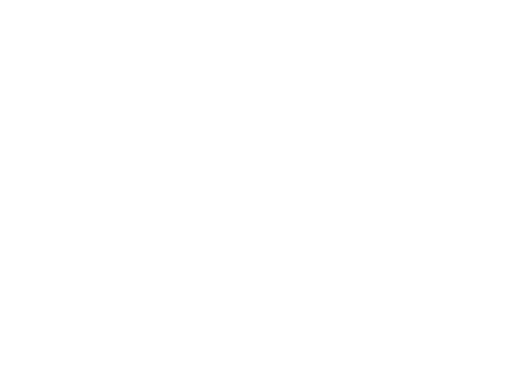

gravity


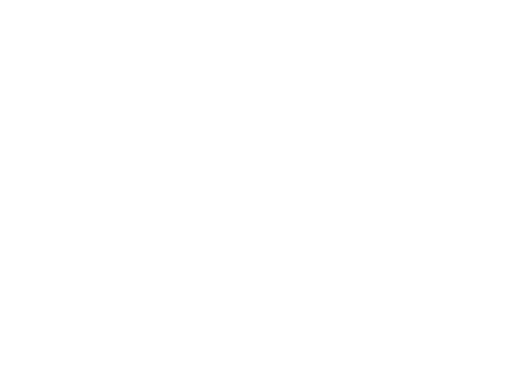

gravity


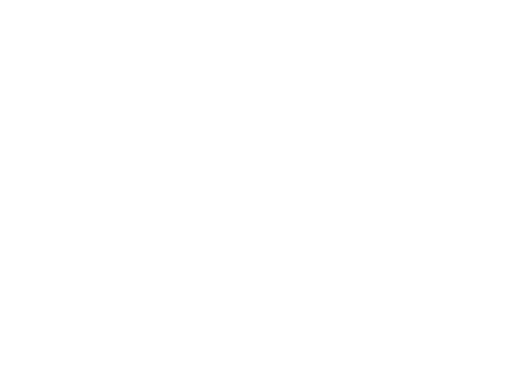

gravity


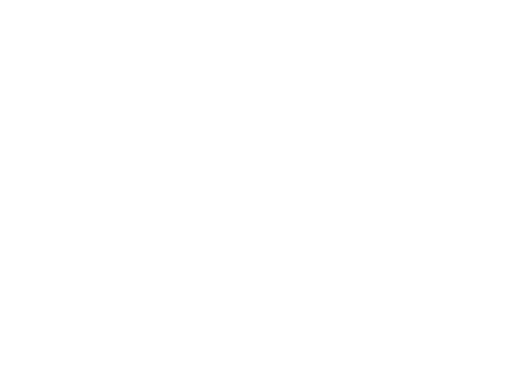

gravity


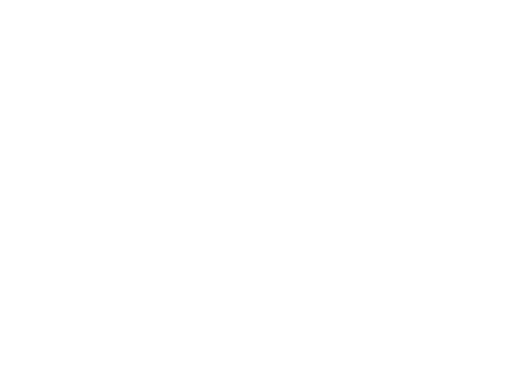

gravity


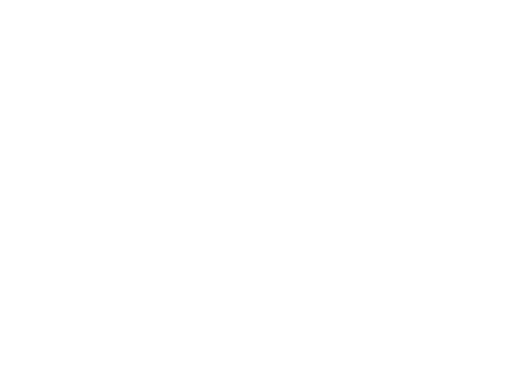

gravity


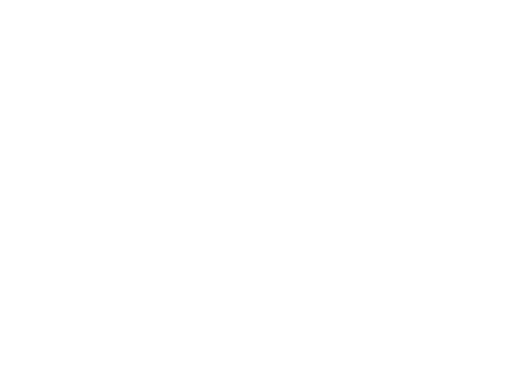

gravity


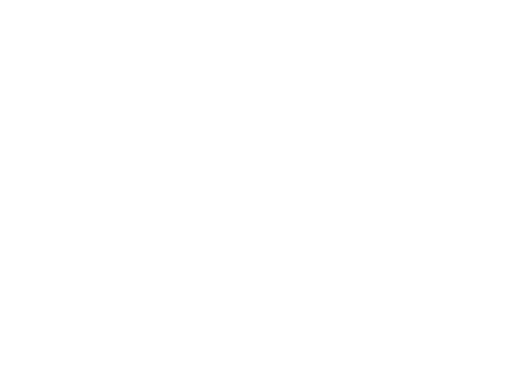

gravity


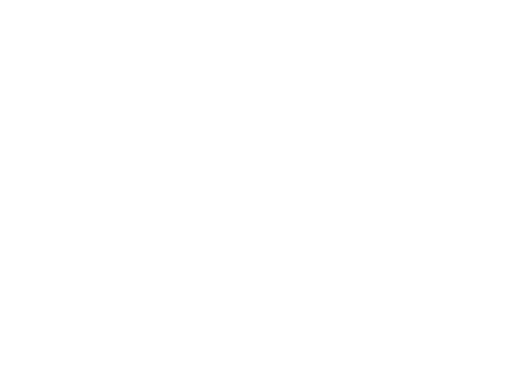

gravity


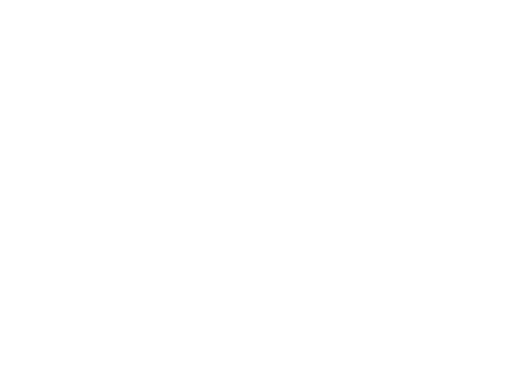

gravity


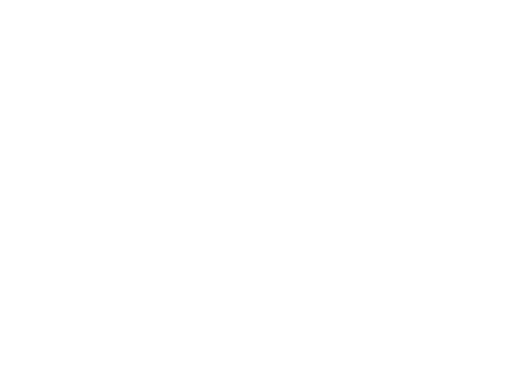

gravity


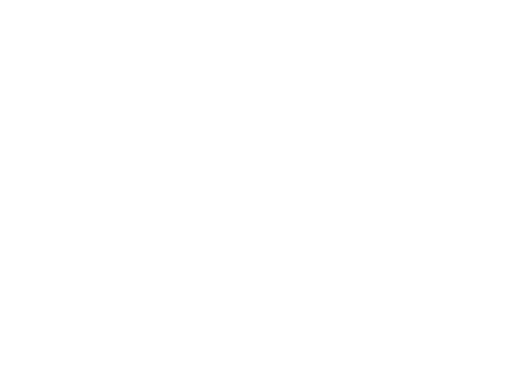

gravity


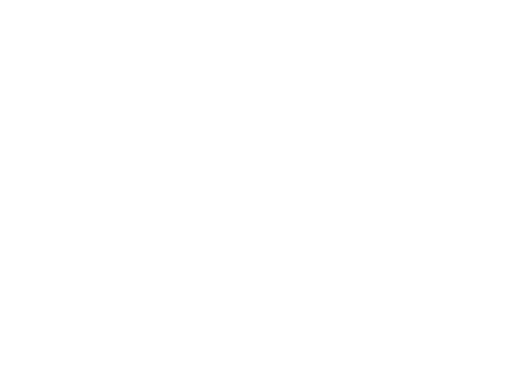

gravity


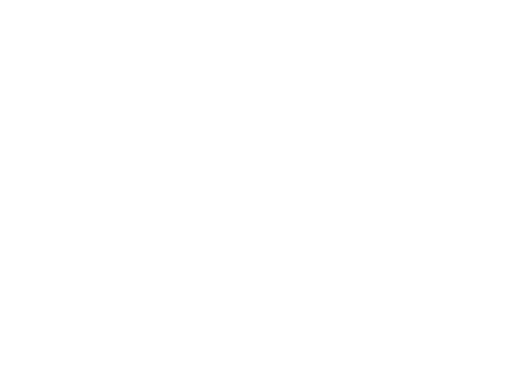

gravity


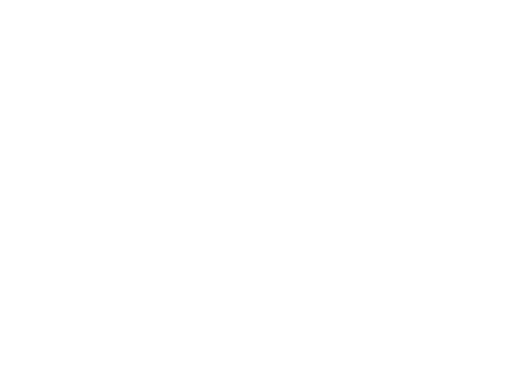

gravity


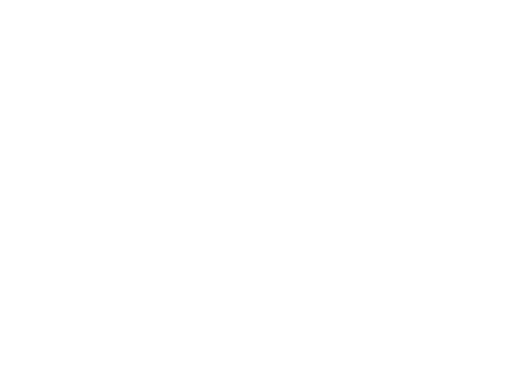

gravity


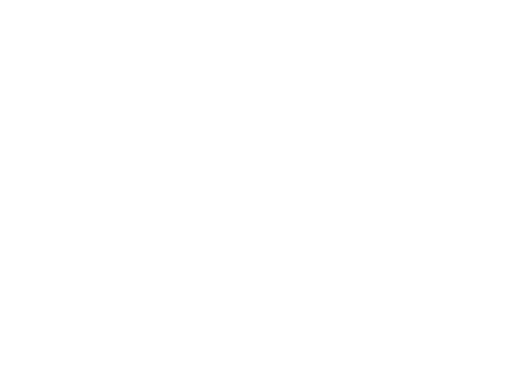

gravity


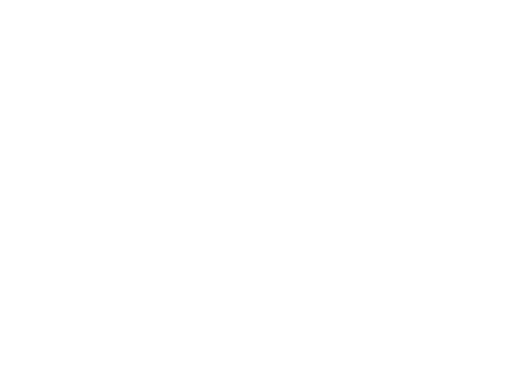

gravity


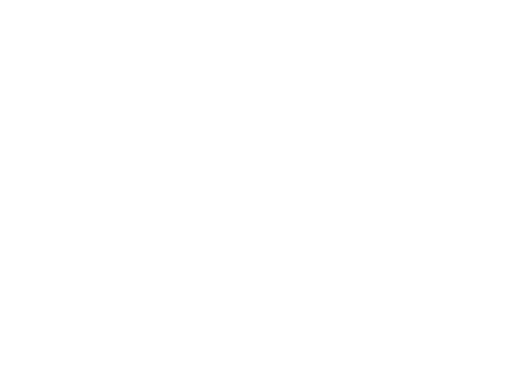

gravity


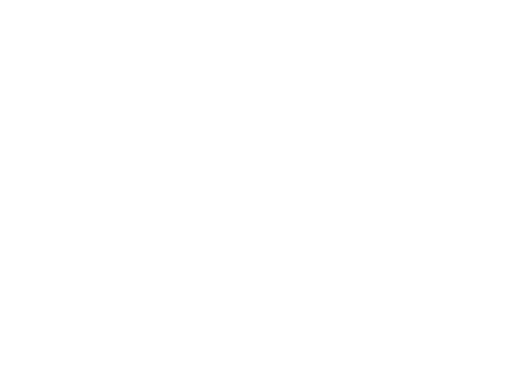

gravity


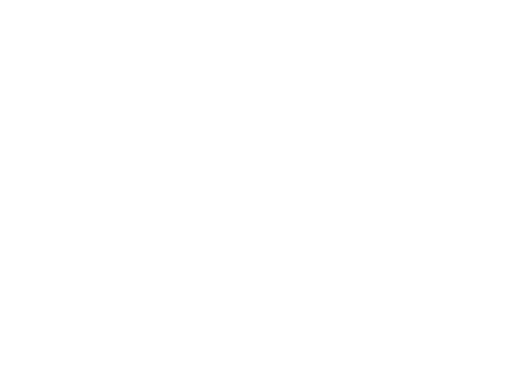

gravity


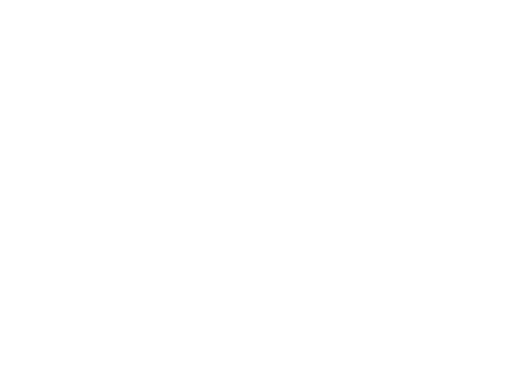

collision detected!
side wall False
side diff ball False
below wall False
below diff ball True
around wall False
around diff ball False


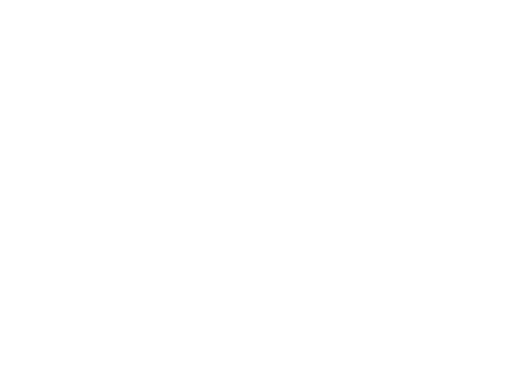

gravity


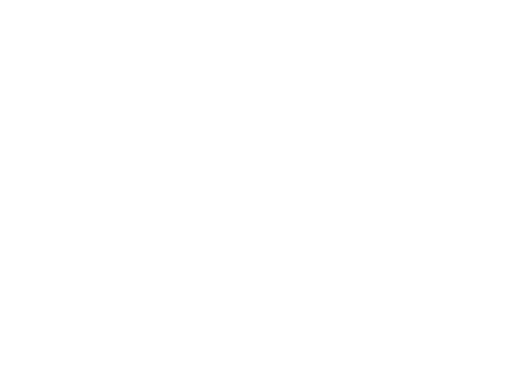

gravity
Current Placements: {(975, 197): 15, (975, 309): 15, (975, 259): 15, (960, 366): 30, (915, 306): 45, (945, 454): 45}


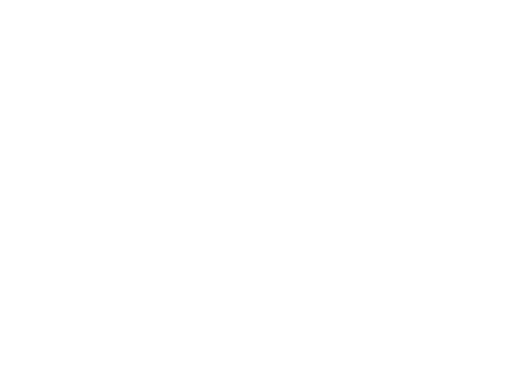

gravity


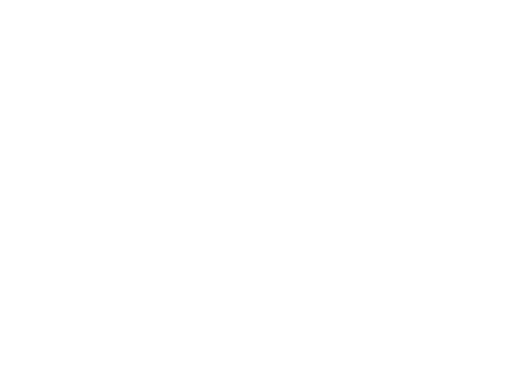

gravity


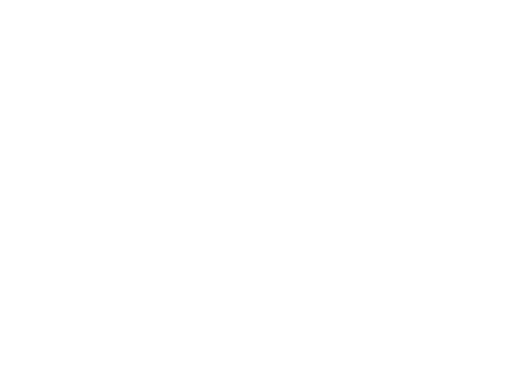

gravity


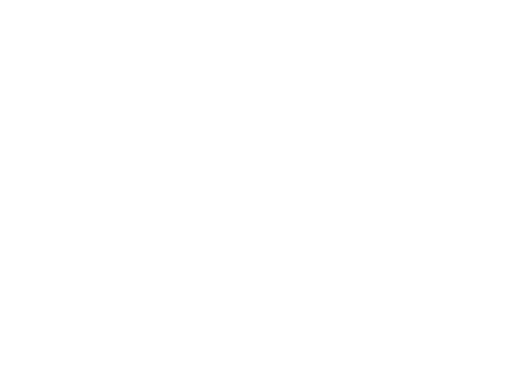

gravity


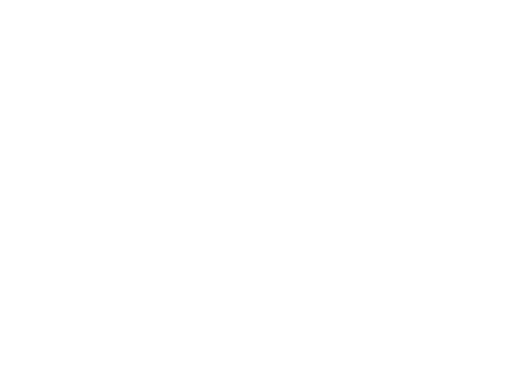

gravity


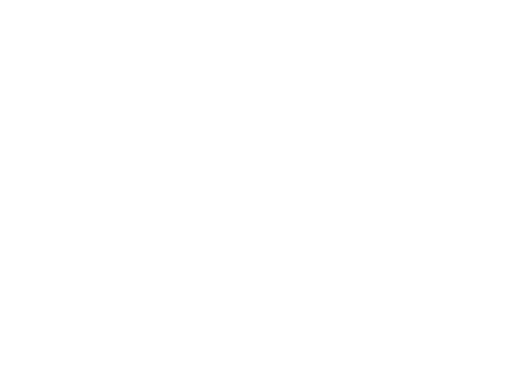

gravity


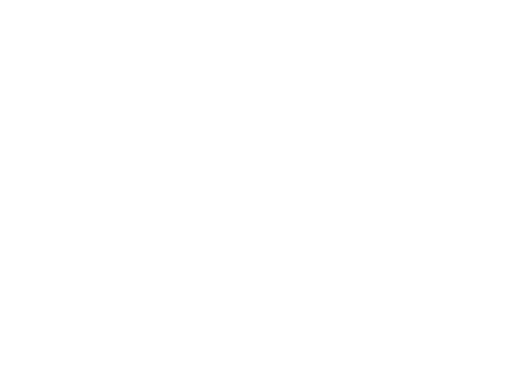

gravity


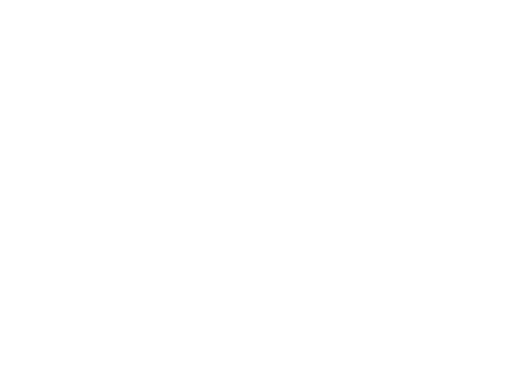

gravity


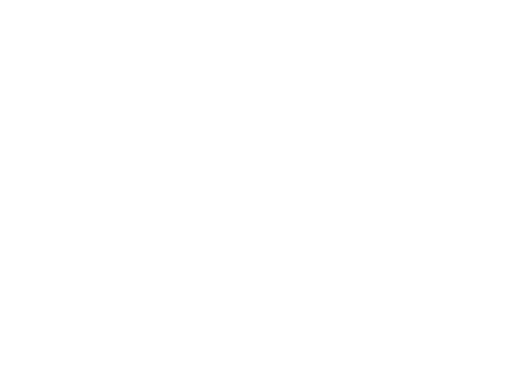

gravity


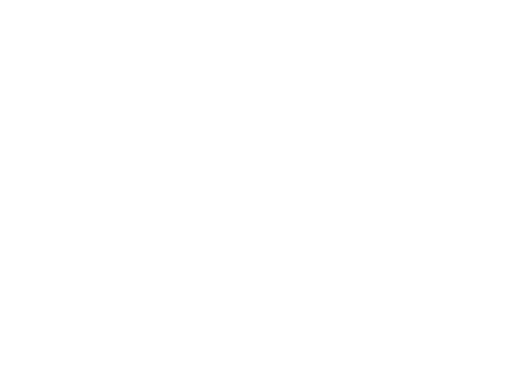

gravity


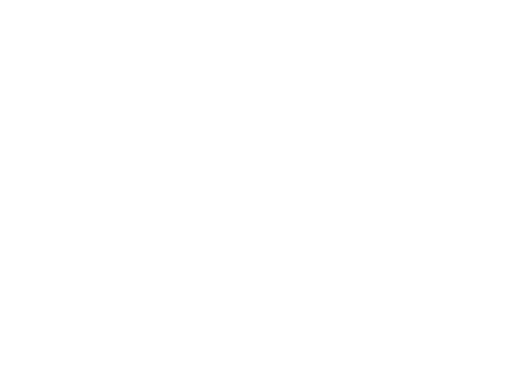

gravity


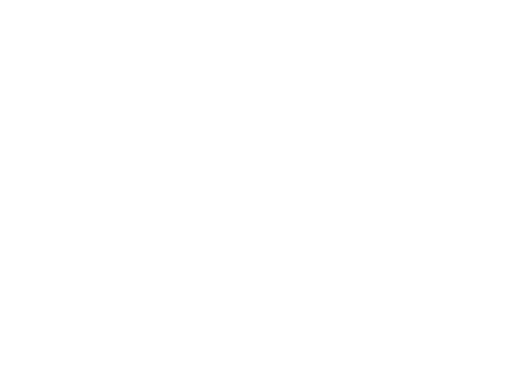

gravity


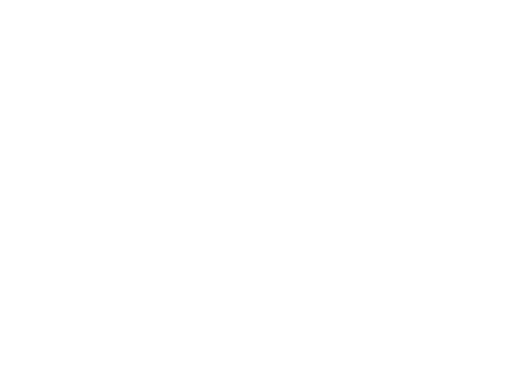

gravity


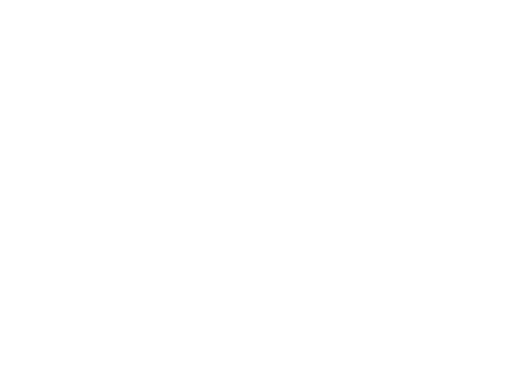

gravity


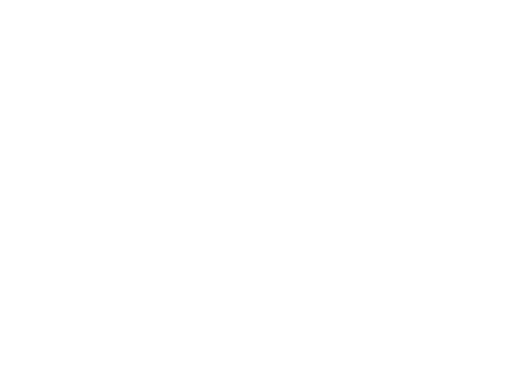

gravity


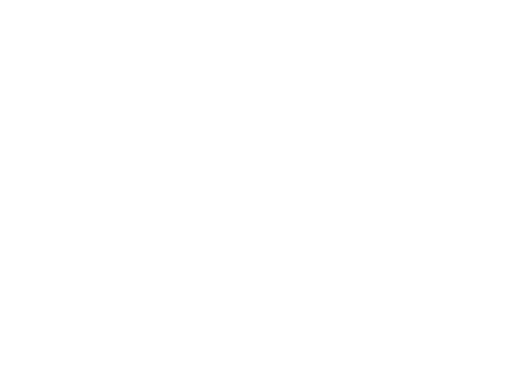

gravity


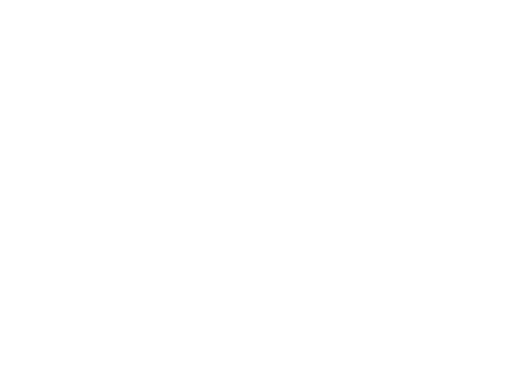

gravity


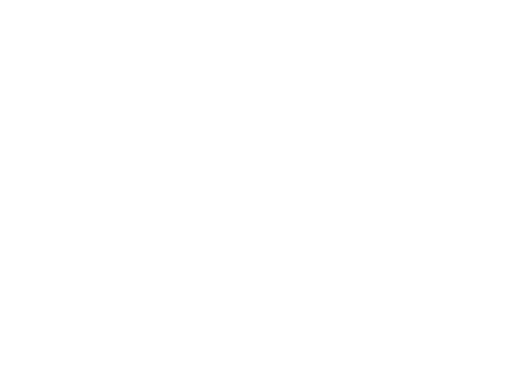

gravity


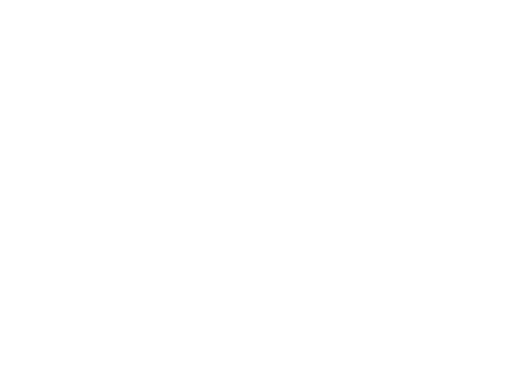

gravity


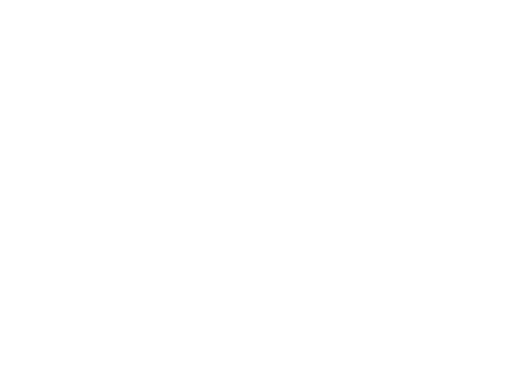

gravity


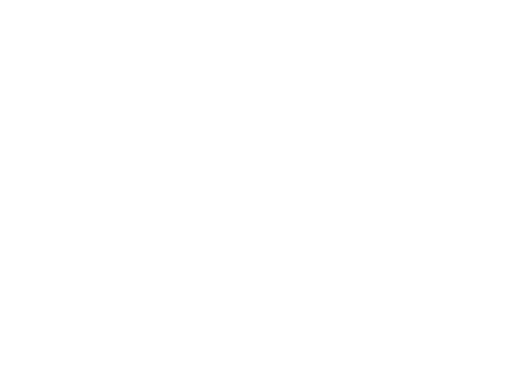

gravity


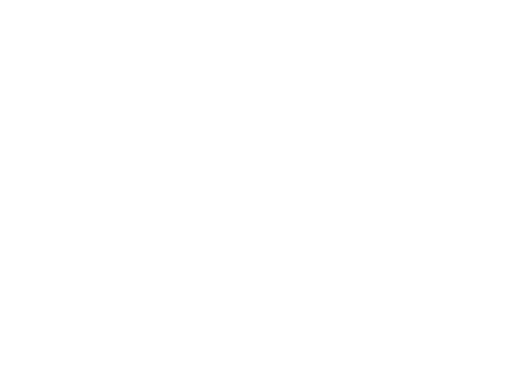

gravity


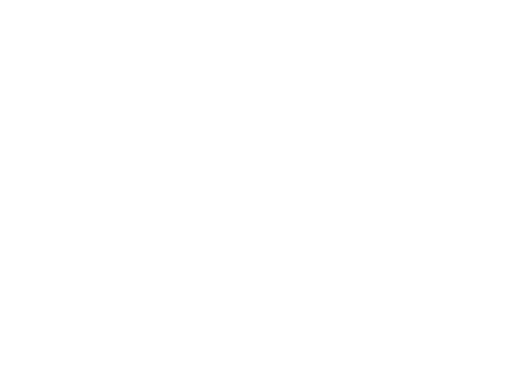

gravity


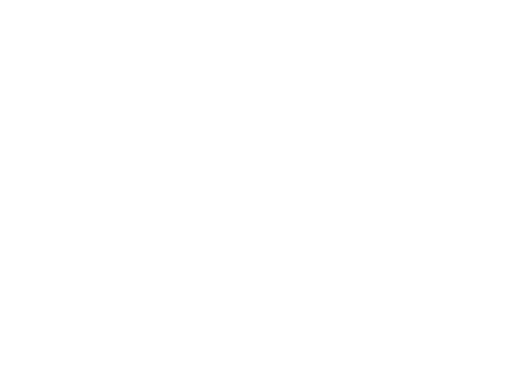

gravity


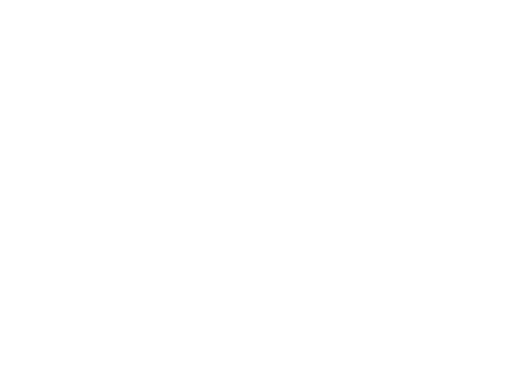

collision detected!
side wall False
side diff ball False
below wall False
below diff ball True
around wall False
around diff ball False


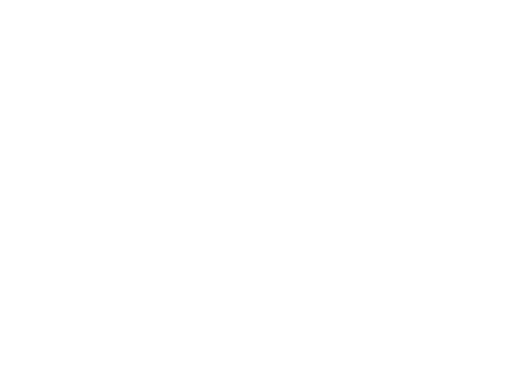

gravity


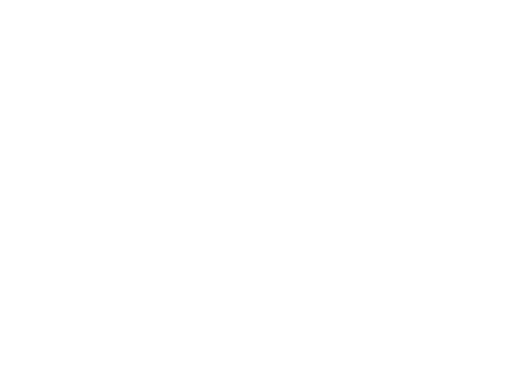

collision detected!
side wall False
side diff ball True
below wall False
below diff ball True
around wall False
around diff ball False
Current Placements: {(975, 197): 15, (975, 309): 15, (975, 259): 15, (960, 366): 30, (915, 306): 45, (945, 454): 45, (840, 391): 60}


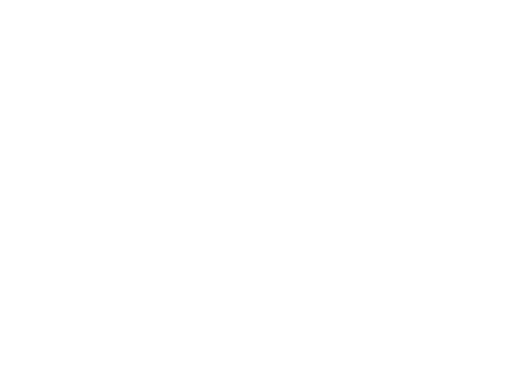

gravity


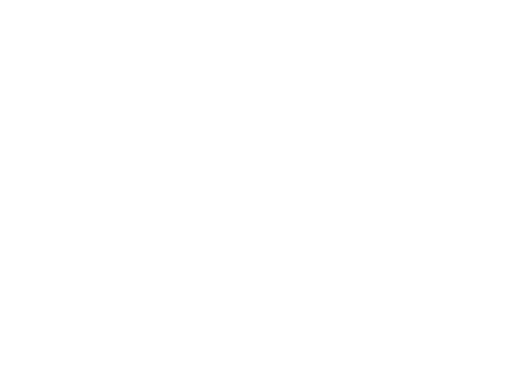

gravity


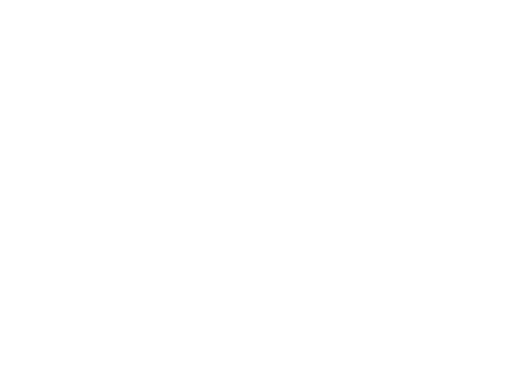

gravity


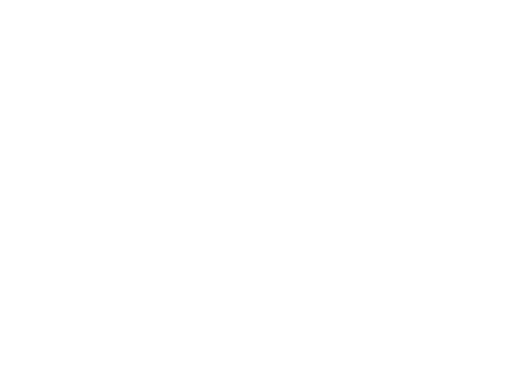

gravity


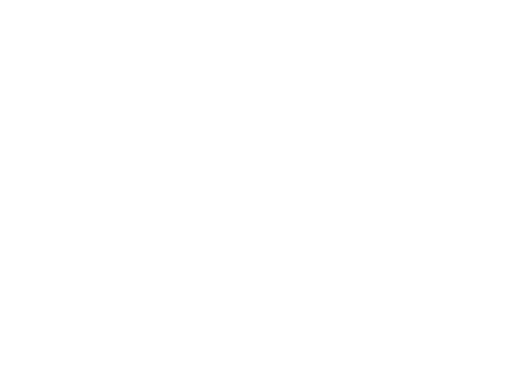

gravity


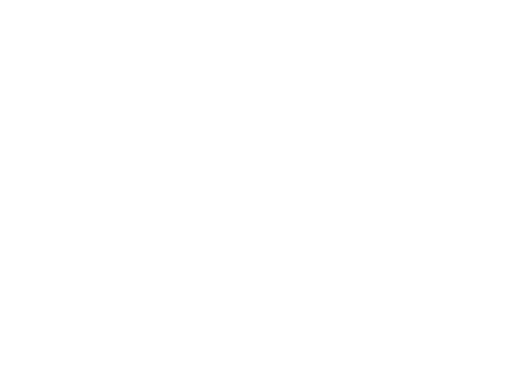

gravity


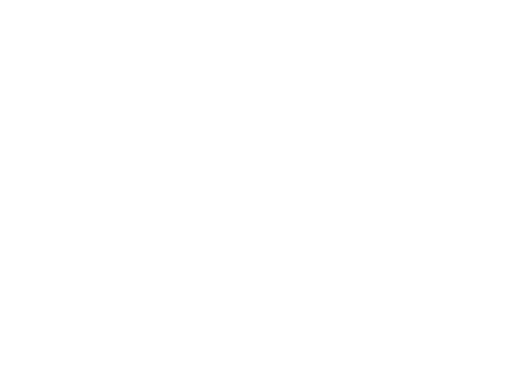

gravity


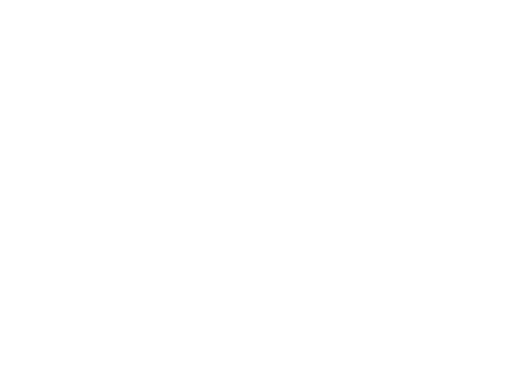

gravity


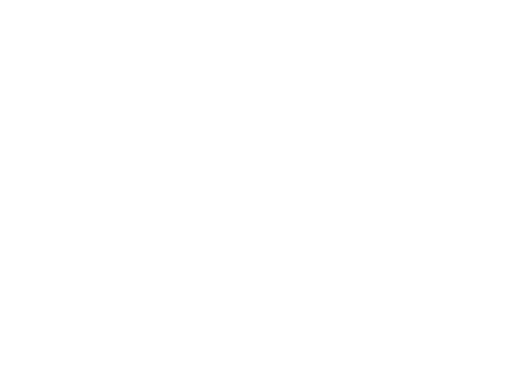

gravity


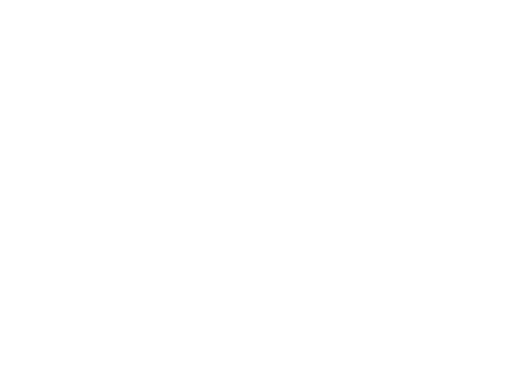

gravity


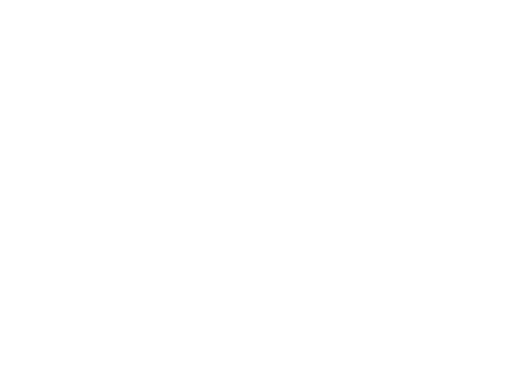

gravity


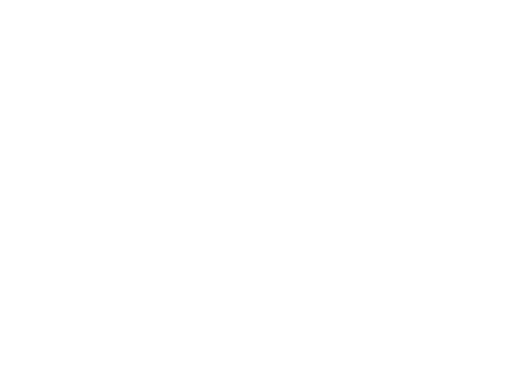

gravity


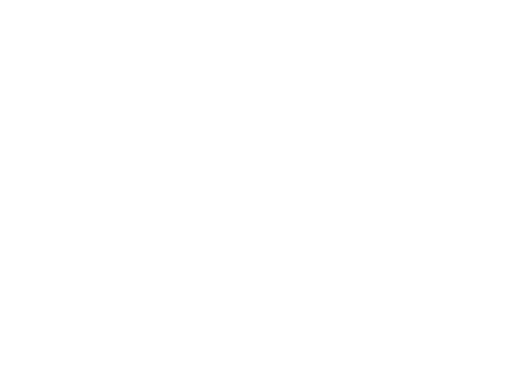

gravity


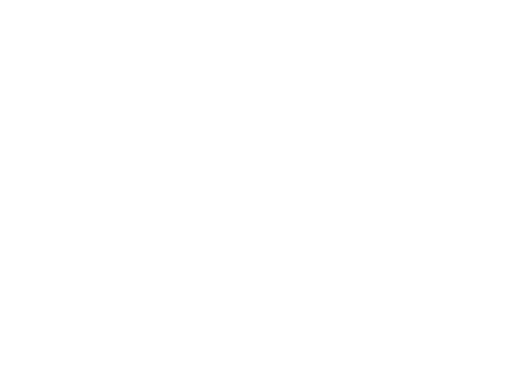

gravity


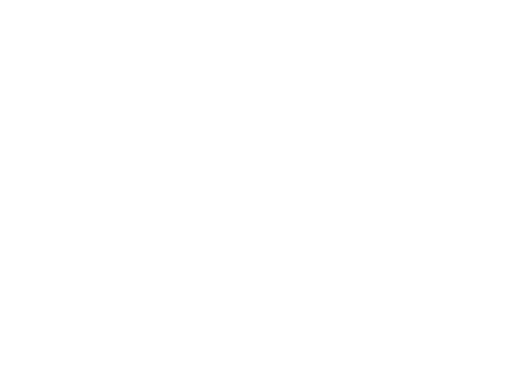

gravity


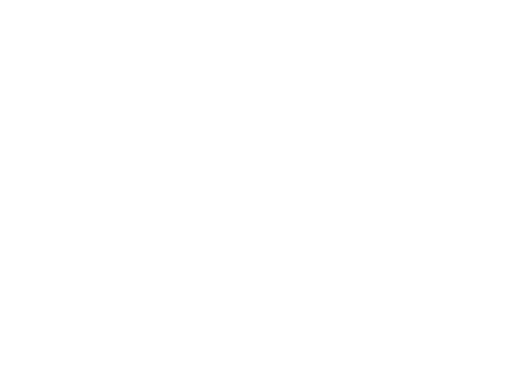

gravity


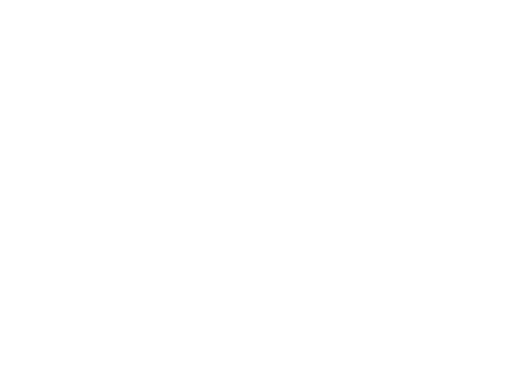

gravity


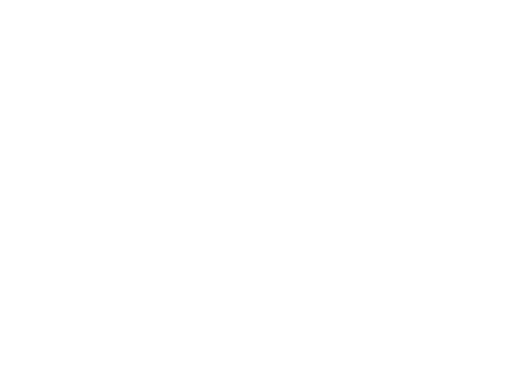

gravity


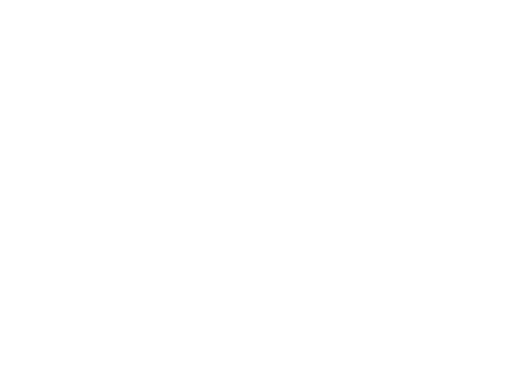

gravity


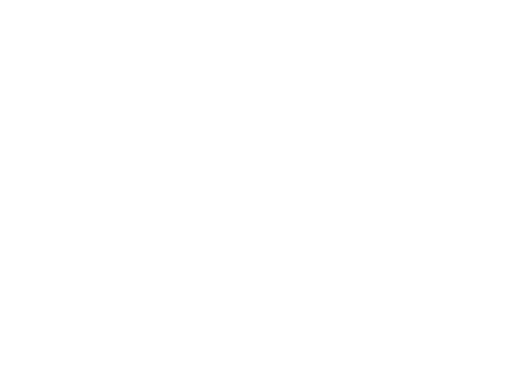

gravity


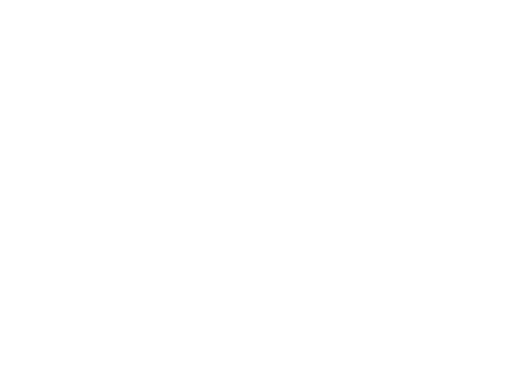

collision detected!
side wall False
side diff ball False
below wall False
below diff ball True
around wall False
around diff ball False


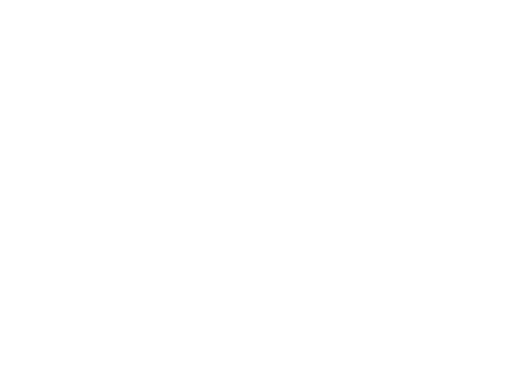

gravity


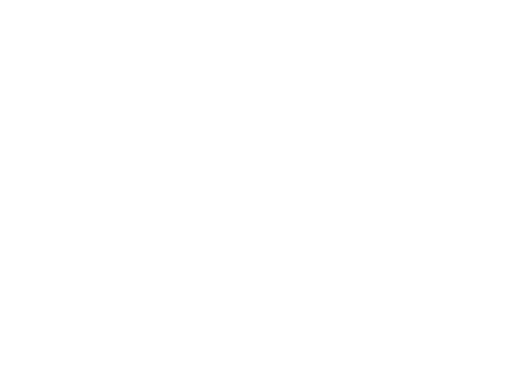

collision detected!
side wall False
side diff ball True
below wall False
below diff ball True
around wall False
around diff ball True
Current Placements: {(975, 197): 15, (975, 309): 15, (975, 259): 15, (960, 366): 30, (915, 306): 45, (945, 454): 45, (840, 391): 60, (735, 304): 75}


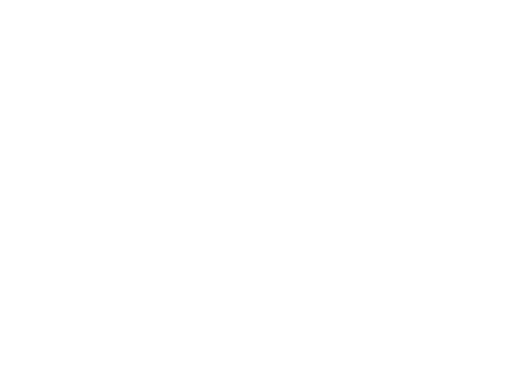

gravity


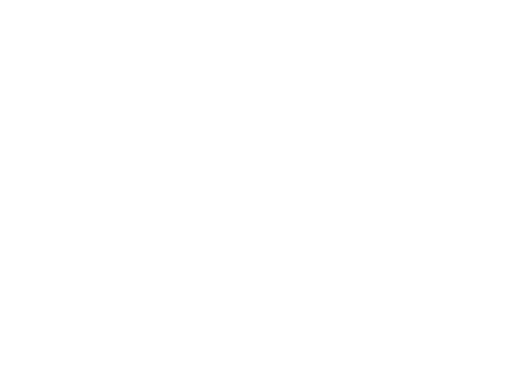

gravity


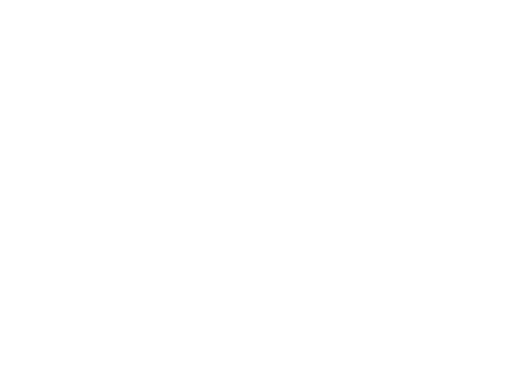

gravity


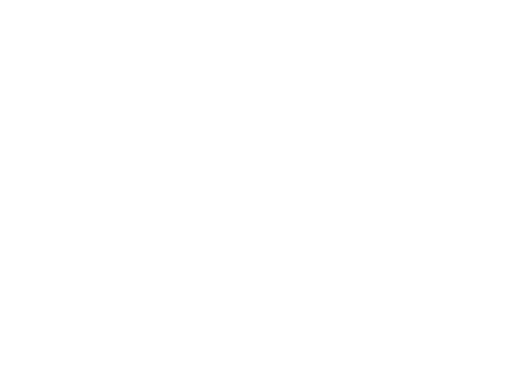

gravity


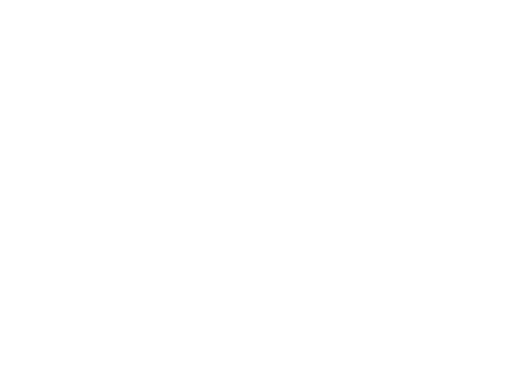

gravity


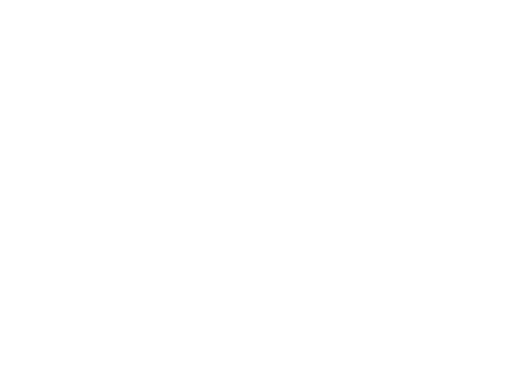

gravity


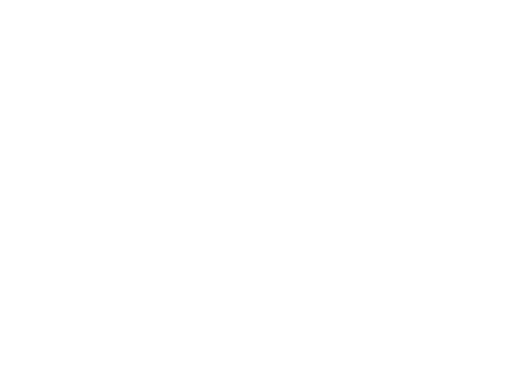

gravity


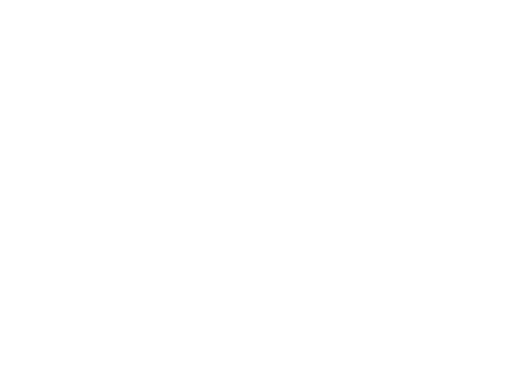

gravity


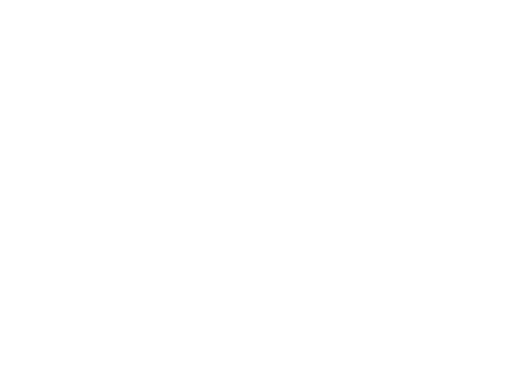

gravity


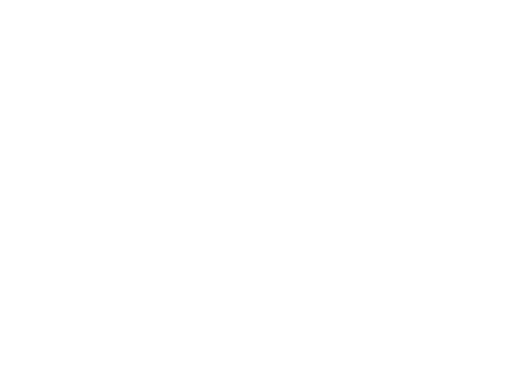

gravity


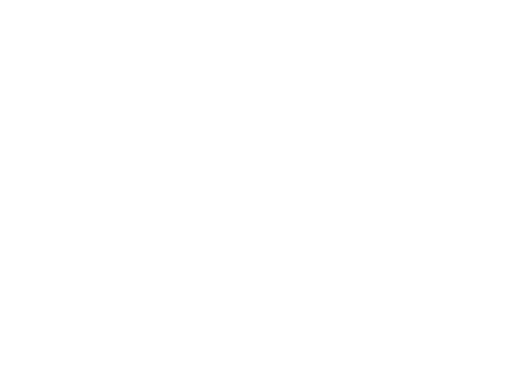

gravity


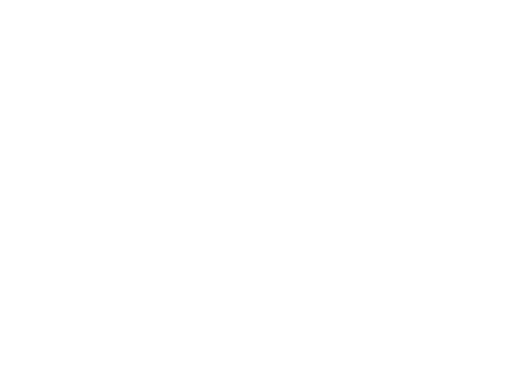

gravity


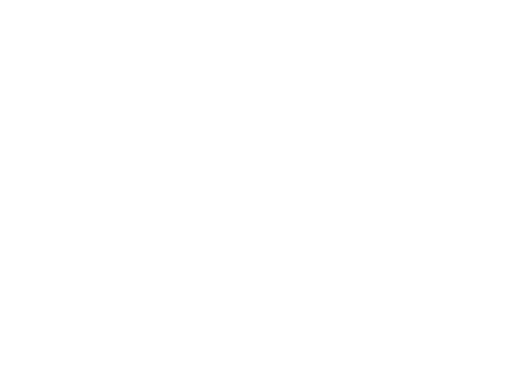

gravity


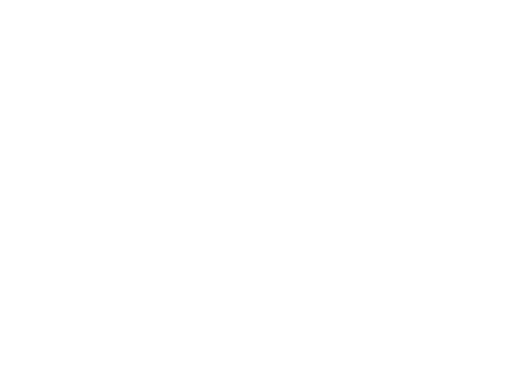

gravity


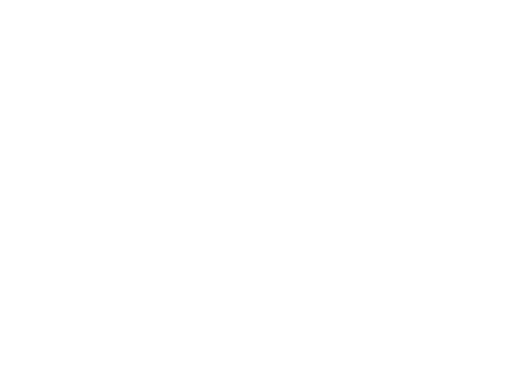

gravity


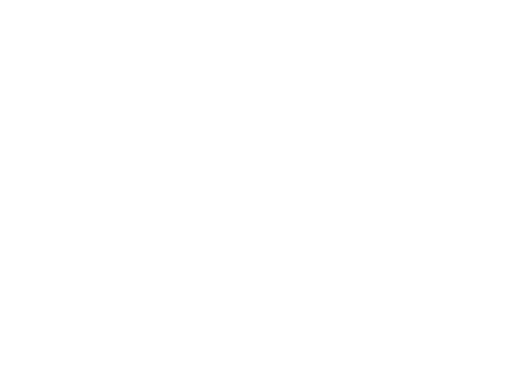

gravity


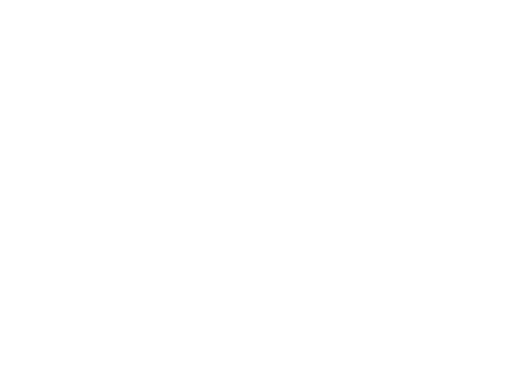

gravity


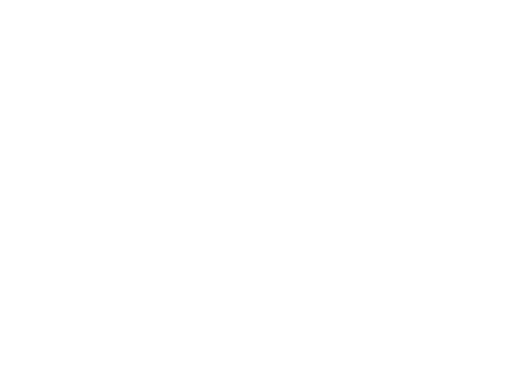

gravity


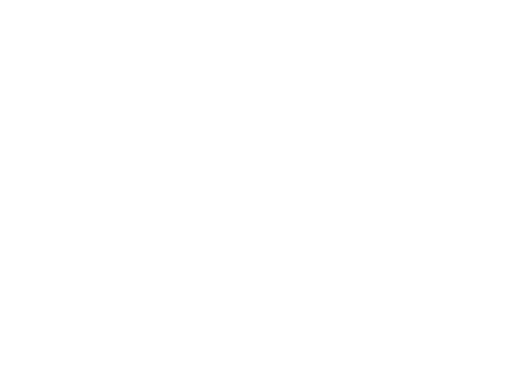

gravity


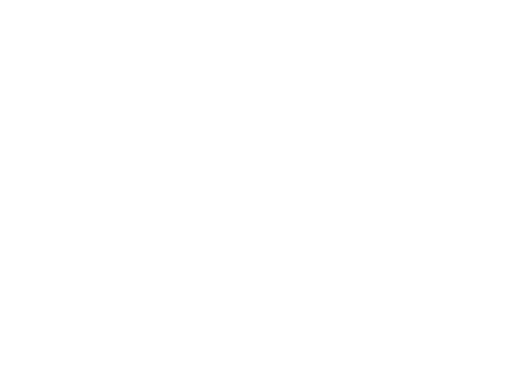

gravity


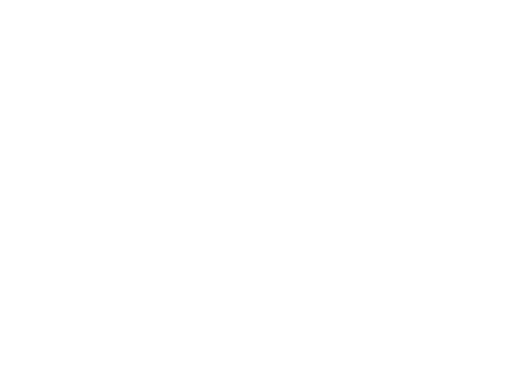

gravity


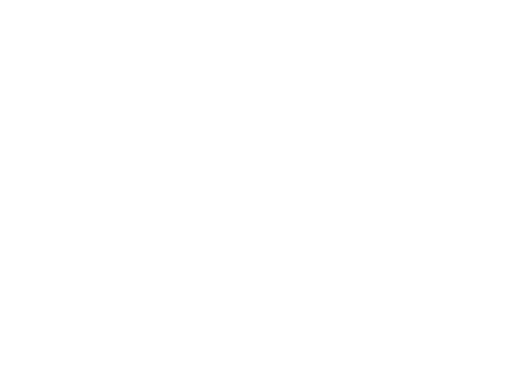

gravity


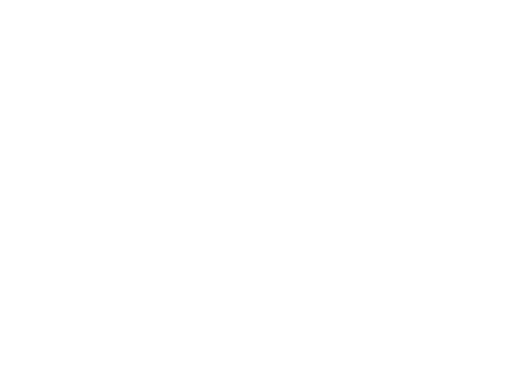

gravity


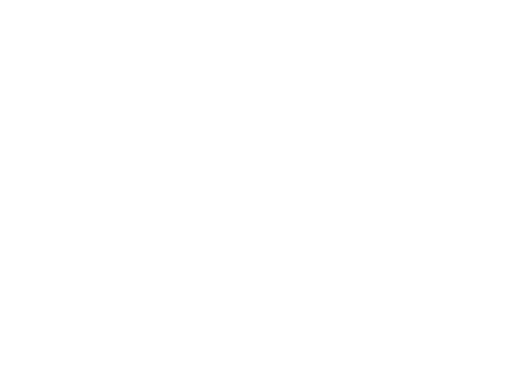

gravity


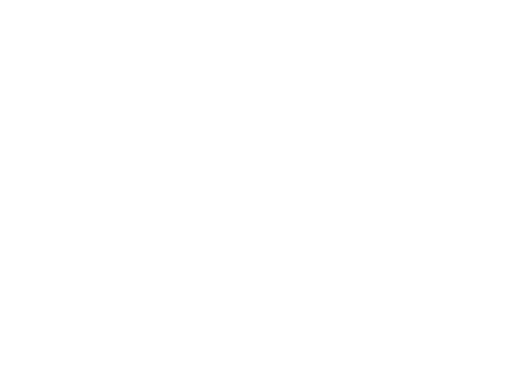

gravity


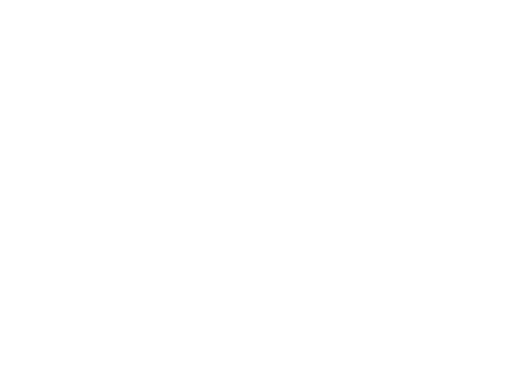

gravity


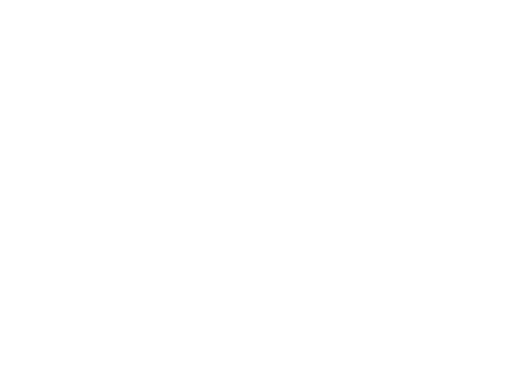

gravity


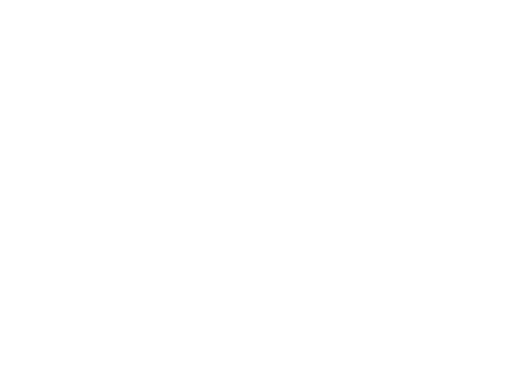

gravity


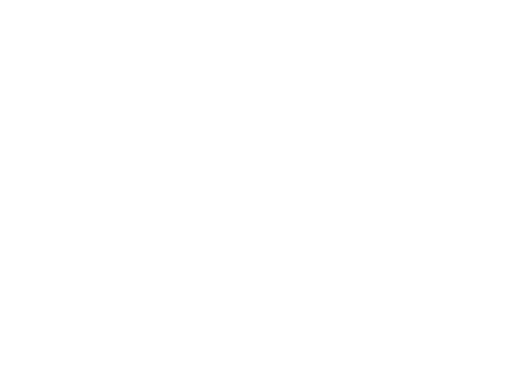

gravity


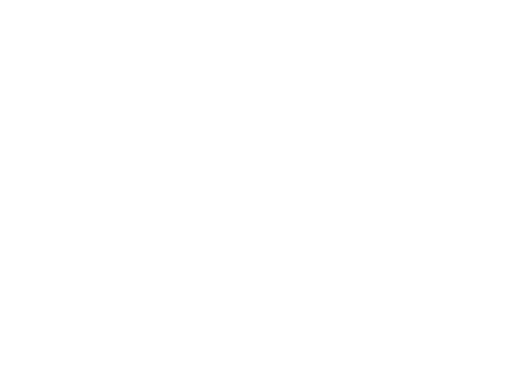

gravity


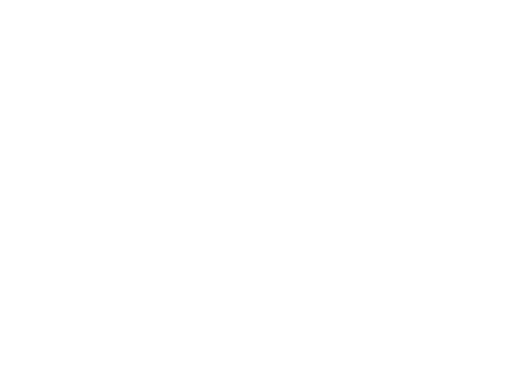

gravity
Current Placements: {(975, 197): 15, (975, 309): 15, (975, 259): 15, (960, 366): 30, (915, 306): 45, (945, 454): 45, (840, 391): 60, (735, 304): 75, (975, 633): 15}


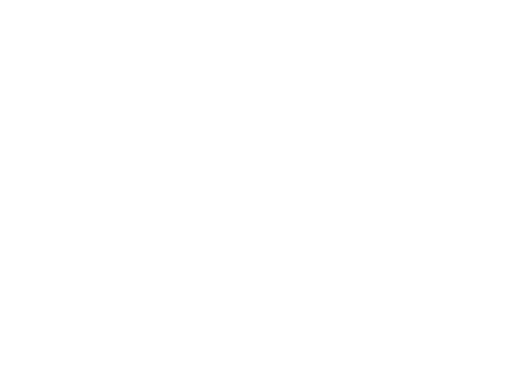

gravity


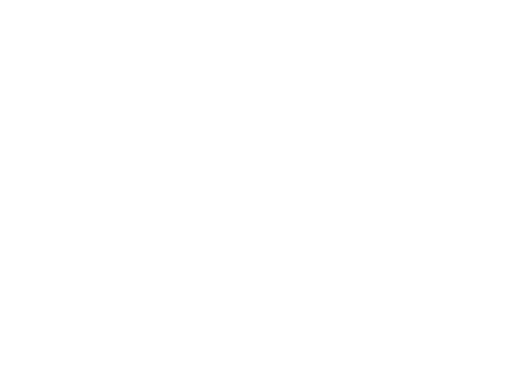

gravity


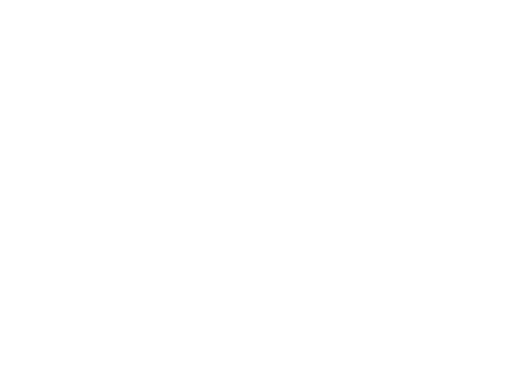

gravity


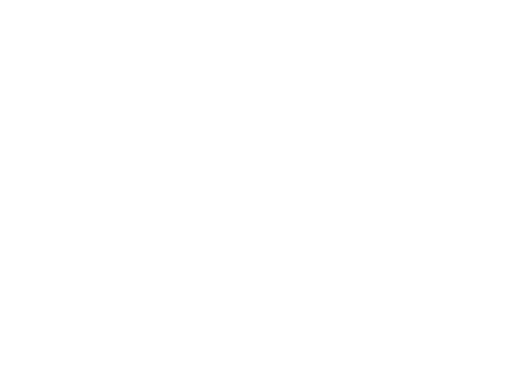

gravity


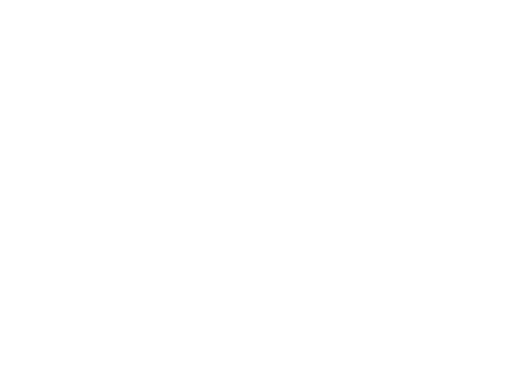

gravity


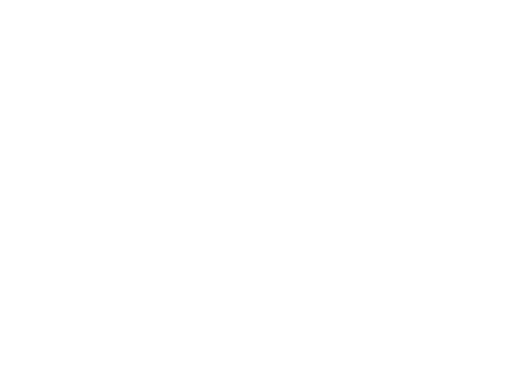

gravity


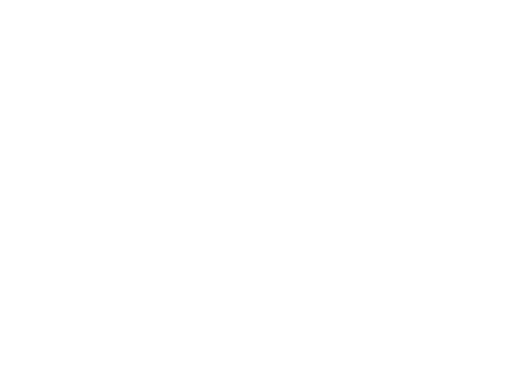

gravity


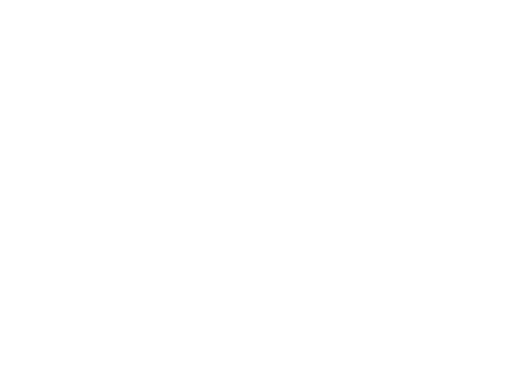

gravity


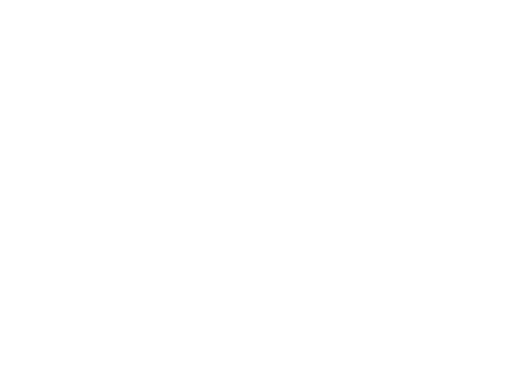

gravity


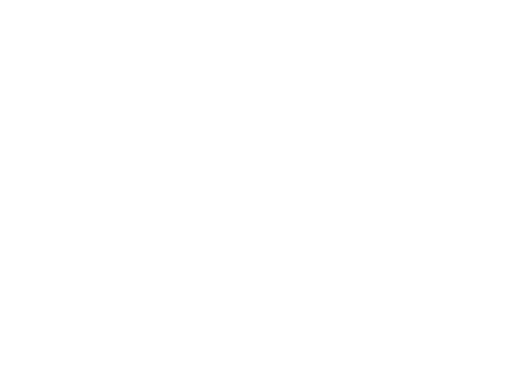

gravity


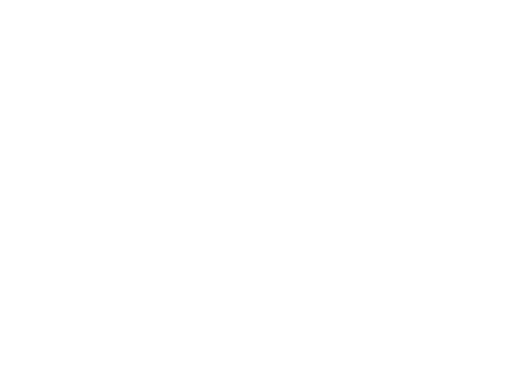

gravity


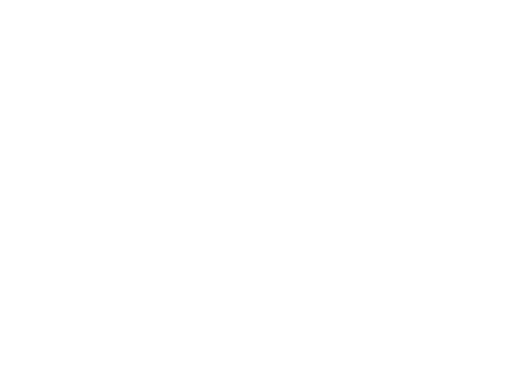

In [ ]:
largest_fruit_radius = FRUITS_BY_INDEX[len(FRUIT_NAMES) - 1]['radius']
x_pos_array = [x_pos for x_pos in range(largest_fruit_radius, game_width - largest_fruit_radius - 1)]
n = 5000

with writer.saving(fig, "animation2.mp4", dpi=200):
    for i in range(n):
        print('current_game', i)
        game_score = 0
        game_cp = np.copy(game)
        game_state = {}
        for fruit in initial_fruits:
            x_pos = np.random.choice(x_pos_array)
            drop_fruit(game_cp, metrics, x_pos, fruit, i)
        if game_score > best_game_score:
            best_game_score = game_score
            best_game_number = i